# Laboratorio 2 - Agrupación

Grupo 14


## Entendimiento de datos

Dentro de este laboratorio se hará uso de los datos pertenecientes al archivo `Datos_SenecaféAlpes.csv`. A continuación, se detalla el proceso de carga, entendimiento y calidad de datos.


In [168]:
import os
import numpy as np
import pandas as pd
from sklearn import tree
import sklearn as sklearn
import matplotlib.cm as cm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plots
import seaborn as sns

sns.set()


from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
)

# Modelos
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN

# Métricas
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    silhouette_score,
    davies_bouldin_score,
    silhouette_samples,
)
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import PCA
import joblib

np.random.seed(42)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

In [169]:
# Carga de datos
df = pd.read_csv("Datos_SenecaféAlpes.csv", encoding="UTF-8", sep=";")
df.shape

(14291, 19)

Para entender el significado de cada una de las columnas se incluye el diccionario.


In [170]:
diccionario = pd.read_excel("Diccionario_SenecaféAlpes.xlsx")
pd.set_option("display.max_colwidth", None)
display(diccionario)

,ATRIBUTO,DESCRIPCIÓN
0,ID,Código único generado para cada grano de café inspeccionado.
1,Área,"Superficie ocupada por el grano, medida como el número total de píxeles dentro de sus límites. Indica el tamaño del grano."
2,Perímetro,"Longitud de la frontera del grano, equivalente a su circunferencia. Refleja la complejidad y continuidad del borde."
3,LongitudEjeMayor,Distancia entre los extremos de la línea más larga que puede trazarse a lo largo del grano. Representa la longitud máxima del grano.
4,LongitudEjeMenor,Longitud de la línea más larga que puede trazarse perpendicular al eje mayor. Refleja el ancho máximo transversal del grano.
5,RelaciónAspecto,Relación entre la longitud del eje mayor y la del eje menor. Indica si el grano es Alargado (> 1.3) o Redondeado (≤ 1.3).
6,Excentricidad,"Medida de la desviación de la forma respecto a un círculo, basada en la elipse equivalente. Valores cercanos a 0 indican formas circulares; cercanos a 1, formas alargadas."
7,ÁreaConvexa,Número de píxeles contenidos en el polígono convexo más pequeño que abarca el grano. Permite identificar irregularidades en el borde.
8,DiámetroEquivalente,Diámetro de un círculo con el mismo área que el grano. Facilita la comparación entre granos de distintas formas mediante una medida circular equivalente.
9,Medida,Proporción entre el área del grano y el área de su caja delimitadora (bounding box). Evalúa qué tan bien el grano ocupa su espacio mínimo rectangular.


In [171]:
df.head()

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [172]:
df.dtypes

ID                      object
Area                     int64
Perimetro              float64
LongitudEjeMayor       float64
LongitudEjeMenor       float64
RelacionAspecto         object
Excentricidad          float64
AreaConvexa            float64
DiametroEquivalente    float64
Medida                 float64
Solidez                float64
Redondez               float64
Compacidad             float64
FactorForma1           float64
FactorForma2           float64
FactorForma3           float64
FactorForma4           float64
DefectoVisible          object
MétodoSecado            object
dtype: object

In [173]:
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,14291.000000,1.305400e+04,13890.000000,14291.000000,13687.000000,12868.000000,12368.000000,14291.000000,11985.000000,12228.000000,13641.000000,13172.000000,13185.000000,13813.000000,13132.000000
mean,53055.408999,7.729870e+05,319.985592,202.178613,0.749977,53575.397809,253.001741,0.749844,0.986774,0.873080,0.799242,0.006560,0.001712,0.643183,0.994292
std,29396.080372,3.266493e+05,86.378452,45.494541,0.099438,29566.387814,60.542330,0.050774,0.025947,0.063237,0.067643,0.001164,0.000601,0.100857,0.039081
min,-62716.000000,-1.012143e+06,-421.444657,-200.838672,-0.835004,-78423.000000,-448.402605,-0.798706,-0.989042,-0.896861,-0.843901,-0.007982,-0.002673,-0.683269,-0.998527
25%,36338.000000,6.768608e+05,253.319858,175.881052,0.715144,36720.000000,215.302463,0.718767,0.985597,0.832824,0.762127,0.005903,0.001151,0.581047,0.993663
50%,44660.000000,7.720345e+05,296.682345,192.437870,0.764392,45107.500000,238.579492,0.760232,0.988279,0.883353,0.800994,0.006645,0.001691,0.641648,0.996377
75%,61311.000000,9.554098e+05,376.548109,216.847844,0.810441,62109.250000,279.672481,0.786942,0.989991,0.916803,0.834405,0.007273,0.002169,0.696366,0.997889
max,254616.000000,1.921685e+06,738.860154,460.198497,0.911423,251082.000000,569.374358,0.866195,0.994378,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

A partir de los tipos de dato de cada columna, se identifica que existen 3 columnas categóricas: DefectoVisible, MétodoSecado y RelacionAspecto. Aparte de la columna ID la cual será ignorada.


In [175]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]
print(numeric_cols)
print(categorical_cols)

['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida', 'Solidez', 'Redondez', 'Compacidad', 'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4']
['ID', 'RelacionAspecto', 'DefectoVisible', 'MétodoSecado']


## Histograma por atributo

A continuación, se presenta un histograma por atributo. Con este se puede ver que los atributos `Solidez`, `FactorForma4`, `Redondez` y `Compacidad`tienen una distribución centrada en valores de 1 o muy cercanos. Otros atributos como `Area`, `LongitudEjeMenor`, `LongitudEjeMayor`, `AreaConvexa` y `DiametroEquivalente` tienen colas de datos a la derecha. Finalmente, el `Perimetro` tiene una distribución con unos datos hacía la derecha y datos muy cercanos a 0. Este comportamiento debe revisarse para identificar si se trata de outliers o si es una consecuencia de otros factores.


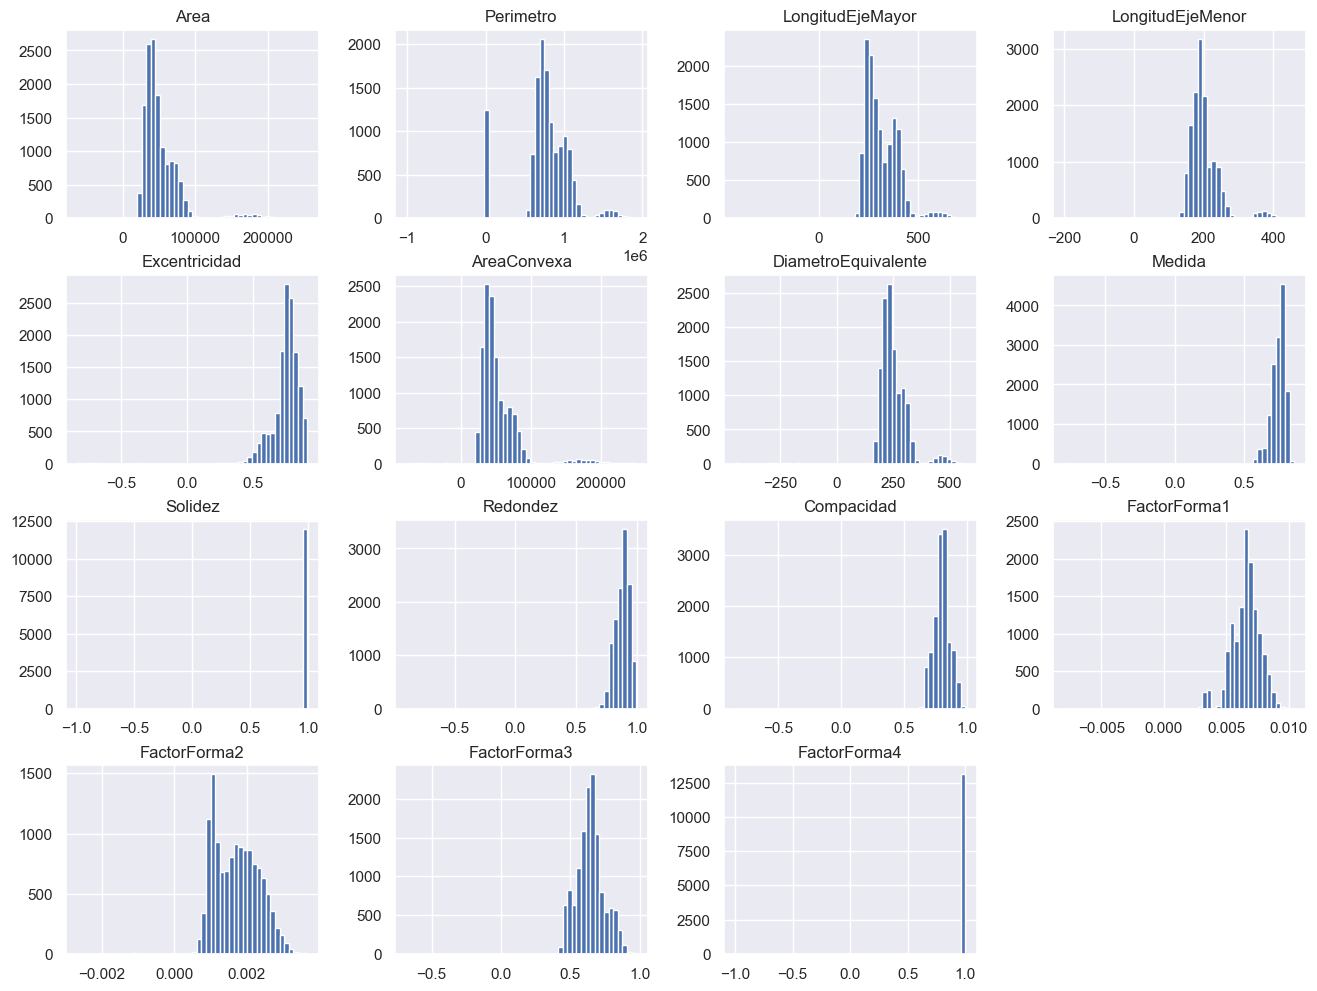

In [176]:
df.hist(bins=50, figsize=(16, 12))
plt.show()

## Completitud


In [177]:
print("Datos Nulos")
print(df.isnull().sum())

Datos Nulos
ID                        0
Area                      0
Perimetro              1237
LongitudEjeMayor        401
LongitudEjeMenor          0
RelacionAspecto         466
Excentricidad           604
AreaConvexa            1423
DiametroEquivalente    1923
Medida                    0
Solidez                2306
Redondez               2063
Compacidad              650
FactorForma1           1119
FactorForma2           1106
FactorForma3            478
FactorForma4           1159
DefectoVisible         2935
MétodoSecado            587
dtype: int64


In [178]:
print("Proporción Datos Nulos")
print((df.isnull().sum() / len(df)) * 100)

Proporción Datos Nulos
ID                      0.000000
Area                    0.000000
Perimetro               8.655797
LongitudEjeMayor        2.805962
LongitudEjeMenor        0.000000
RelacionAspecto         3.260794
Excentricidad           4.226436
AreaConvexa             9.957316
DiametroEquivalente    13.456021
Medida                  0.000000
Solidez                16.136030
Redondez               14.435659
Compacidad              4.548317
FactorForma1            7.830103
FactorForma2            7.739137
FactorForma3            3.344762
FactorForma4            8.109999
DefectoVisible         20.537401
MétodoSecado            4.107480
dtype: float64


Con el cálculos de valores nulos por columna, se puede ver que los atributos con mayor falta de información son: DefectoVisible, Solidez, Redondez, y DiametroEquivalente. En general, se deben considerar técnicas de imputación ya que hay muy pocos atributos que cuenten con una información totalmente completa.
Para los atributos numéricos se puede usar la media de los registros y para los categóricos se propone imputar haciendo uso de la moda.

Para el caso de DefectoVisible ya que el hay un 20.53% de datos vacíos, se completan los datos pero más adelante este detalle se tiene en cuenta debido a que se debe estudiar si este atributo es relevante para el problema o si llega a introducir sesgos.


## Unicidad


In [179]:
df.loc[df.duplicated(keep="first")]

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
384,G001698,44524,758387.0,258.916322,219.129976,Redondeado,NaN,44860.0,238.096026,0.782977,NaN,0.972797,0.919587,0.005815,0.002565,0.845640,0.999178,Normal,Lavado
507,G002702,69824,1055572.0,389.048708,229.112799,Alargado,0.808202,70943.0,298.165521,0.688396,0.984227,0.787479,0.766396,0.005572,0.001186,0.587363,0.997382,Normal,Natural
544,G003108,78848,1088405.0,388.645864,259.122237,Alargado,0.745298,79719.0,316.847584,0.734577,0.989074,0.836411,0.815260,0.004929,0.001343,0.664650,0.996878,Normal,Natural
569,G013443,40125,738378.0,275.637443,185.812657,Alargado,0.738622,40508.0,226.028177,0.774614,0.990545,0.924842,0.820020,0.006869,0.001916,0.672433,0.997497,Normal,Lavado
639,G002184,57995,NaN,324.569677,229.352384,Alargado,0.707578,NaN,271.737976,0.746003,0.982999,0.844240,0.837225,0.005597,0.001696,0.700946,0.991949,Normal,Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14087,G007878,40462,751445.0,278.924258,185.017159,NaN,0.748332,40894.0,226.975370,0.785975,0.989436,0.900457,0.813753,0.006893,0.001865,0.662193,0.998296,Normal,NaN
14089,G003144,79874,1093895.0,382.913187,270.423338,Alargado,0.707986,81979.0,318.902392,0.760755,0.974323,0.838811,0.832832,0.004794,0.001423,0.693609,NaN,Normal,Lavado
14143,G012802,35995,NaN,257.442963,178.548674,Alargado,0.720412,36354.0,NaN,0.795470,0.990125,0.931469,0.831563,0.007152,0.002110,0.691497,0.997045,Normal,Lavado
14159,G001254,40705,738355.0,249.136239,208.625320,Redondeado,0.546599,41147.0,227.655915,0.764413,0.989258,NaN,0.913781,0.006121,0.002632,0.834995,0.997135,Normal,Lavado


In [180]:
df = df.drop_duplicates()

In [181]:
df.shape

(13830, 19)

Se detectaron 461 registros completamente duplicados, los cuales fueron eliminados. Esta decisión se tomó ya que se siguen teniendo 13830 registros, razón por la cual se sigue contando con información suficiente.

Como se tiene la columna de ID del grano, se ignora este atributo y se revisan nuevamente duplicados. Esto con el fin de ver filtrar registrso que puedan presentar problemas para el dataset pese a no se duplicados completos.


In [182]:
df.loc[df.duplicated(subset=df.columns.difference(["ID"]), keep=False)]

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
2063,G005822,46863,867433.0,347.442755,172.128791,Alargado,0.868656,47538.0,244.269983,0.700703,0.985801,0.782651,0.703051,0.007414,0.001117,0.494281,0.997708,Normal,Natural
6343,G005821,46863,867433.0,347.442755,172.128791,Alargado,0.868656,47538.0,244.269983,0.700703,0.985801,0.782651,0.703051,0.007414,0.001117,0.494281,0.997708,Normal,Natural


In [183]:
cols = numeric_cols + categorical_cols
df = df.drop_duplicates(subset=cols)
df.shape

(13830, 19)

Al revisar el caso de duplicados parciales evitando el ID, se encuentra que hay un caso adicional que se debe eliminar.

Como se resolvió la unicidad, se resuelven los problemas de completitud. No se realizó previamente ya que como se va a realizar imputación con media y moda, estos valores estadísticos se pueden ver afectados por duplicados.


In [184]:
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [185]:
print("Proporción Datos Nulos")
print((df.isnull().sum() / len(df)) * 100)

Proporción Datos Nulos
ID                     0.0
Area                   0.0
Perimetro              0.0
LongitudEjeMayor       0.0
LongitudEjeMenor       0.0
RelacionAspecto        0.0
Excentricidad          0.0
AreaConvexa            0.0
DiametroEquivalente    0.0
Medida                 0.0
Solidez                0.0
Redondez               0.0
Compacidad             0.0
FactorForma1           0.0
FactorForma2           0.0
FactorForma3           0.0
FactorForma4           0.0
DefectoVisible         0.0
MétodoSecado           0.0
dtype: float64


Al aplicar imputación de datos, se logra que estos estén completos y no se tengan valores faltantes.


## Consistencia

A continuación, se revisan los datos de cada columna categórica. Esto tiene como fin revisar que tipos de valores hay y tener una noción preliminar de si la codificación es consistente.


In [186]:
df.value_counts("RelacionAspecto", dropna=False)

RelacionAspecto
Alargado      12113
Redondeado     1678
alargado         29
redondeado       10
Name: count, dtype: int64

In [187]:
df.value_counts("DefectoVisible", dropna=False)

DefectoVisible
Normal    11581
normal     2249
Name: count, dtype: int64

In [188]:
df.value_counts("MétodoSecado", dropna=False)

MétodoSecado
Lavado     6552
Natural    4495
lavado     1540
natural    1168
Honey        62
honey        13
Name: count, dtype: int64

Como se puede ver, todas las columnas categóricas tienen información con diferentes tipos de codificación. Es decir, hay diferencias en como se escriben los valores, lo que se debe arreglar para que se pueda manejar apropiadamente estos datos.


In [189]:
df["RelacionAspecto"] = df["RelacionAspecto"].replace("alargado", "Alargado")
df["RelacionAspecto"] = df["RelacionAspecto"].replace("redondeado", "Redondeado")
df["DefectoVisible"] = df["DefectoVisible"].replace("normal", "Normal")
df["MétodoSecado"] = df["MétodoSecado"].replace("lavado", "Lavado")
df["MétodoSecado"] = df["MétodoSecado"].replace("natural", "Natural")
df["MétodoSecado"] = df["MétodoSecado"].replace("honey", "Honey")
df.head()

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836,923618.0,358.515147,181.388899,Alargado,0.749921,53521.754117,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,0.749921,64158.000000,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,Normal,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.000000,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.000000,252.859008,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.000000,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


## Validez

En cuanto a validez, se analiza que los datos tengan sentido dentro del contexto. Para esto, se tendrá especial atención en los datos numéricos. En cuanto a los atributos numéricos, partiendo de la definición del diccionario deberían tener valores positivos.


In [190]:
((df[numeric_cols] < 0).sum() / len(df)) * 100

Area                   0.021692
Perimetro              0.043384
LongitudEjeMayor       0.021692
LongitudEjeMenor       0.028923
Excentricidad          0.065076
AreaConvexa            0.043384
DiametroEquivalente    0.050615
Medida                 0.007231
Solidez                0.014461
Redondez               0.014461
Compacidad             0.028923
FactorForma1           0.043384
FactorForma2           0.050615
FactorForma3           0.021692
FactorForma4           0.036153
dtype: float64

Como el porcentaje de datos faltantes es muy bajo, se decide eliminar los registros que no son validos.


In [191]:
df_clean = df[(df[numeric_cols] >= 0).all(axis=1)]

Finalmente, se codifican las columnas con valores categóricos. Para esto se utiliza One Hot Encoding debido a que no son categorías que tengan orden y se elimina la columna ID ya que no aporta a como atributo al problema.


In [192]:
df_clean = pd.get_dummies(
    df_clean, columns=["MétodoSecado", "DefectoVisible", "RelacionAspecto"]
)
df_clean = df_clean.drop("ID", axis=1)

In [193]:
df_clean.head()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,MétodoSecado_Honey,MétodoSecado_Lavado,MétodoSecado_Natural,DefectoVisible_Normal,RelacionAspecto_Alargado,RelacionAspecto_Redondeado
0,50836,923618.0,358.515147,181.388899,0.749921,53521.754117,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,False,True,False,True,True,False
1,62764,1003767.0,409.207082,198.330199,0.749921,64158.000000,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,False,False,True,True,True,False
2,59965,994266.0,389.088529,197.967275,0.860886,60910.000000,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,False,False,True,True,True,False
3,55035,917.6,379.346822,185.390577,0.872446,55591.000000,252.859008,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,False,True,False,True,True,False
4,39324,737773.0,262.520242,191.176858,0.685326,39758.000000,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,False,True,False,True,True,False


Con la preparación de datos, se generan nuevas gráficas para analizar como están actualmente los datos.


### Histogramas de features


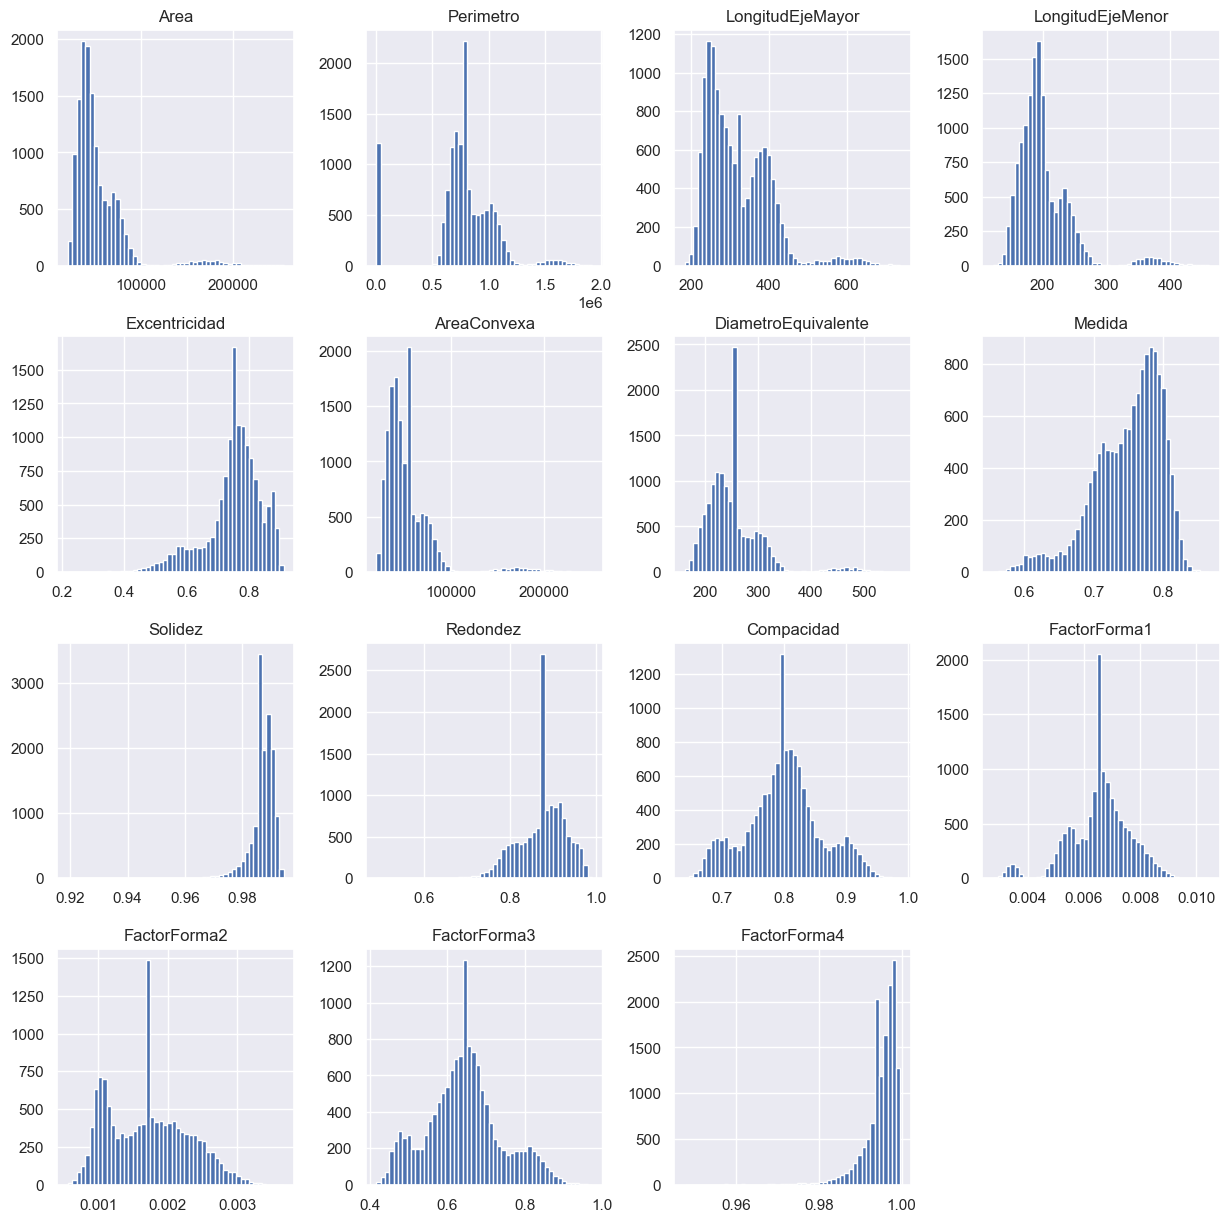

In [194]:
df_clean.hist(bins=50, figsize=(15, 15))
plt.show()

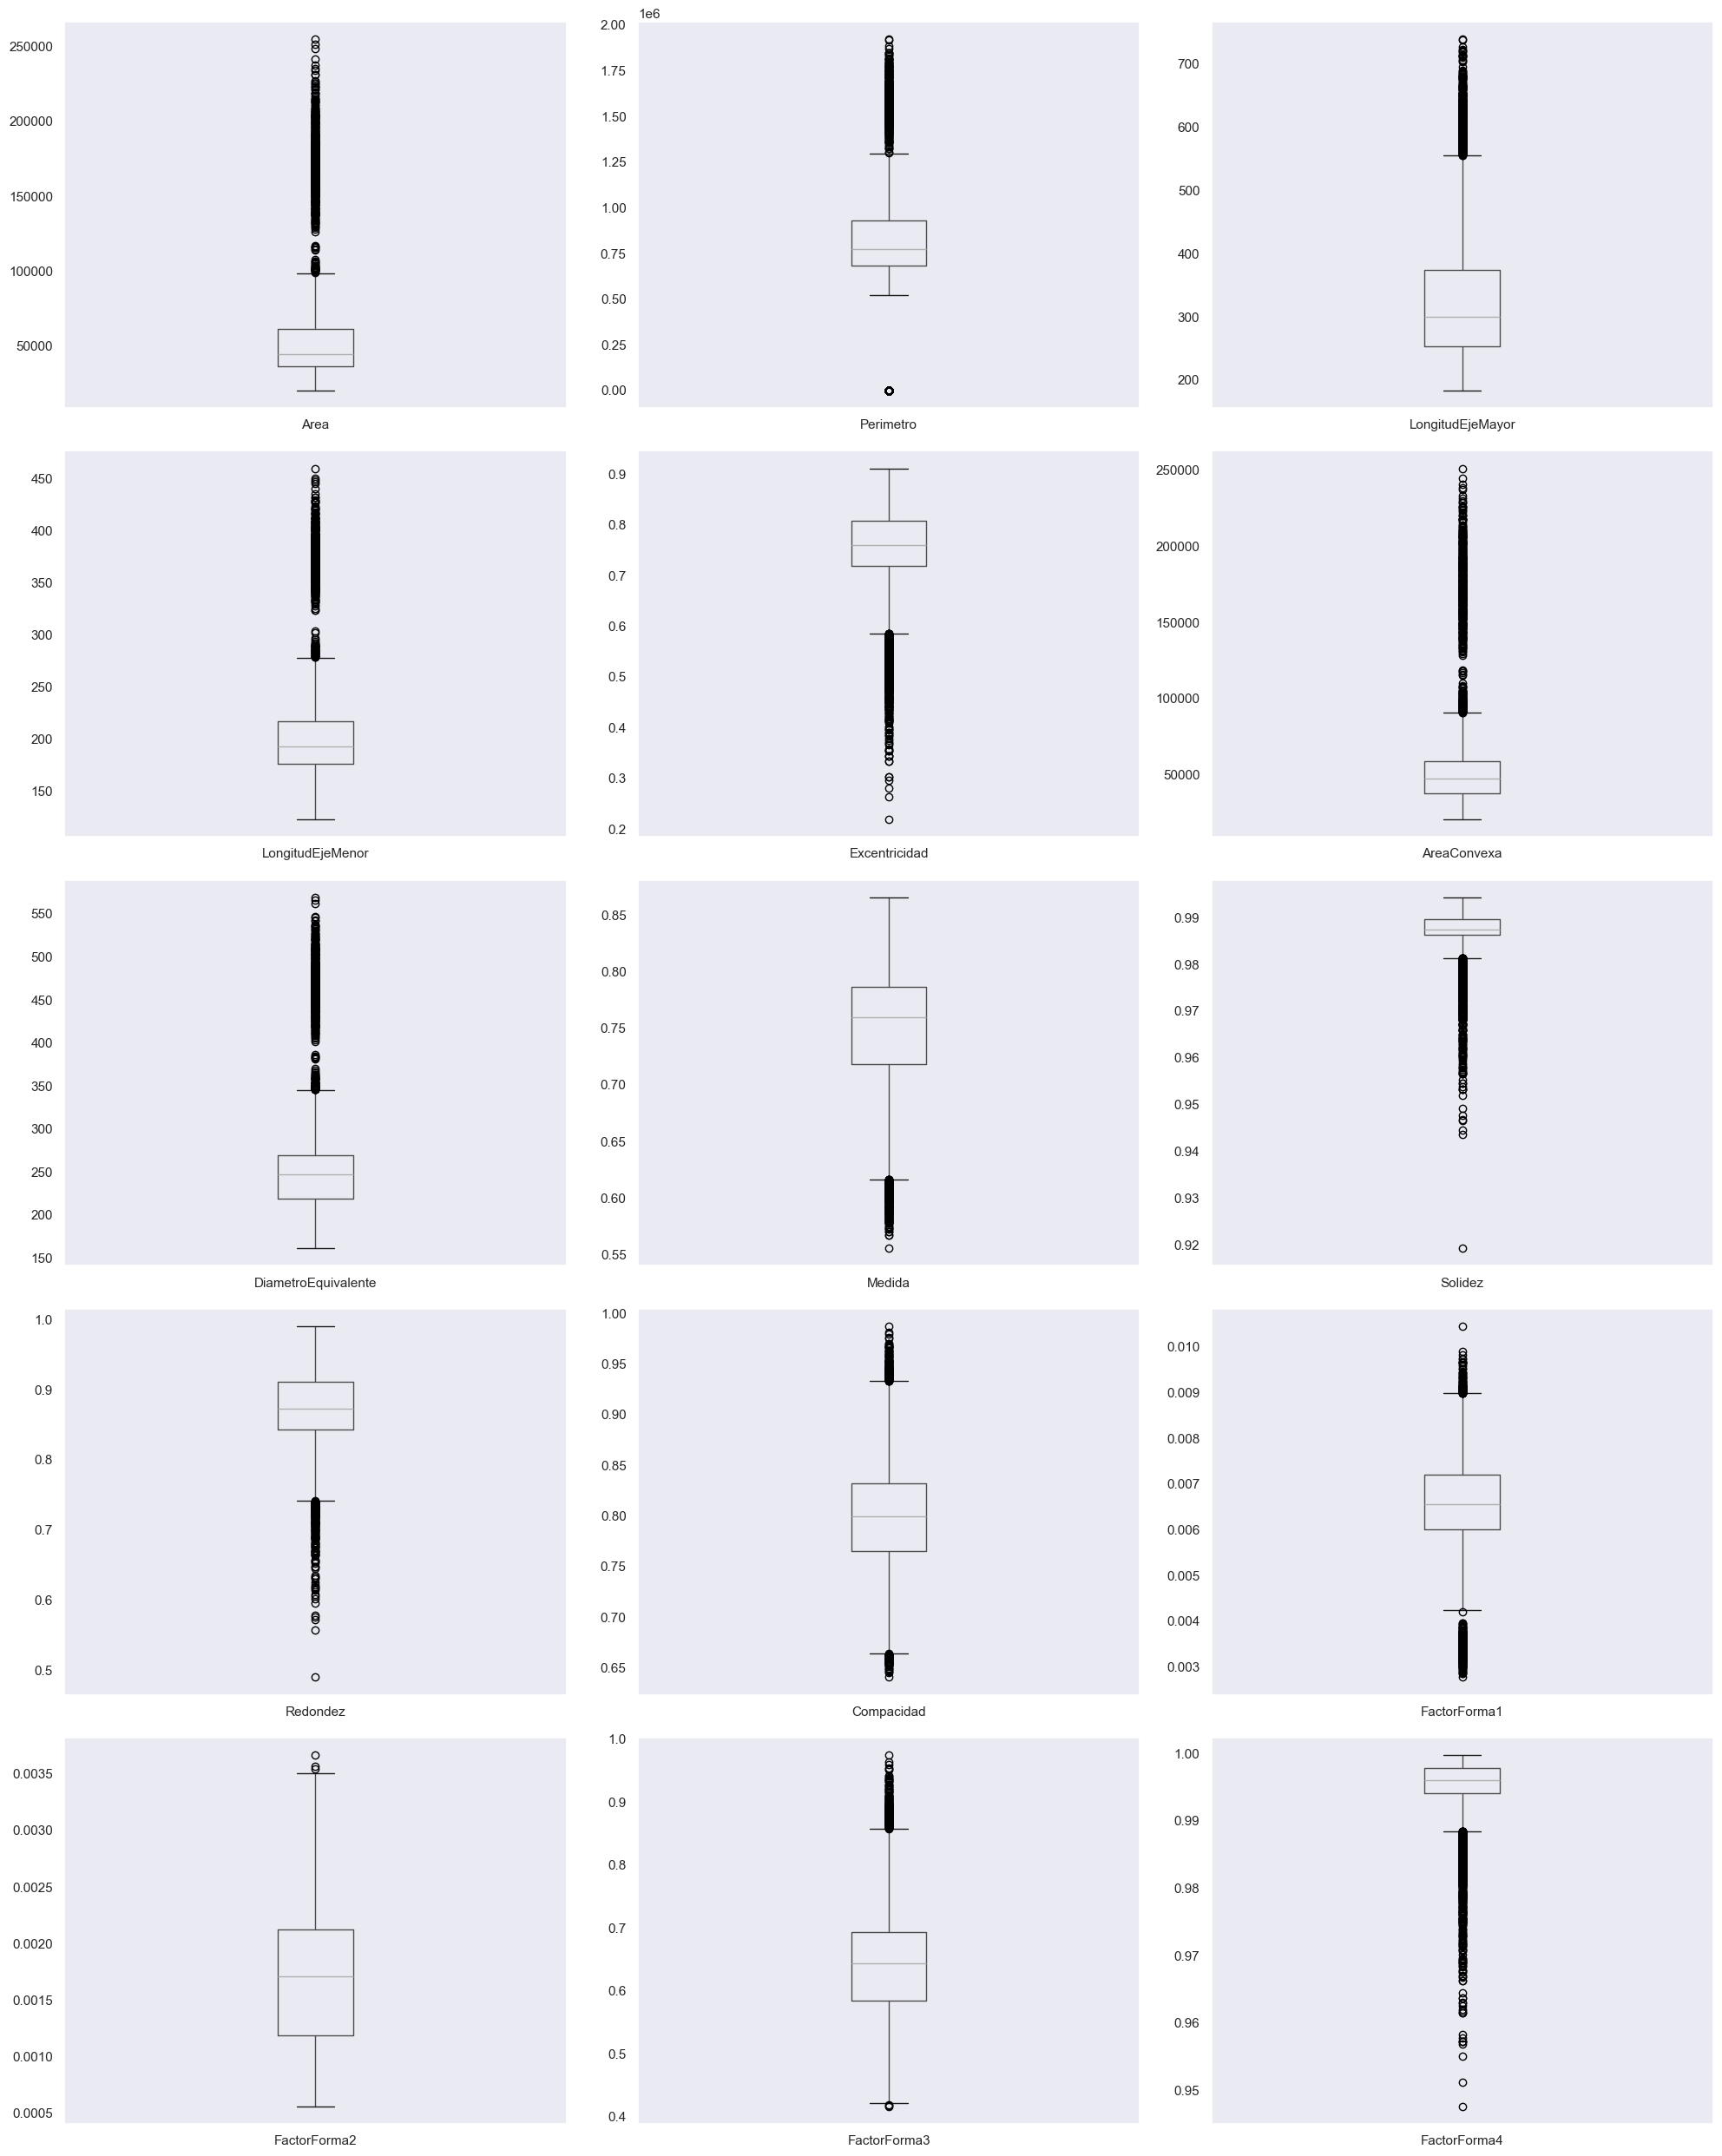

In [195]:
num_cols = len(numeric_cols)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 5 * 5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df_clean.boxplot(column=[col], ax=ax, grid=False)

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Como se puede ver, hay muchos outliers dentro de los datos. Por lo que se entra a revisar por casos.
Para el caso del Perimetro y la Solidez se decide limpiar los datos muy cercanos a 0 puesto que están alejados de la distribución.


In [196]:
((df_clean["Perimetro"] < 0.1 * 1e6).sum() / len(df_clean)) * 100


median = df_clean["Perimetro"][df_clean["Perimetro"] >= 0].median()

df_clean["Perimetro"] = df_clean["Perimetro"].apply(
    lambda x: median if x < 0.1 * 1e6 else x
)

In [197]:
((df_clean["Solidez"] < 0.93).sum() / len(df_clean)) * 100

median = df_clean["Solidez"][df_clean["Solidez"] >= 0].median()

df_clean["Solidez"] = df_clean["Solidez"].apply(lambda x: median if x < 0.93 else x)

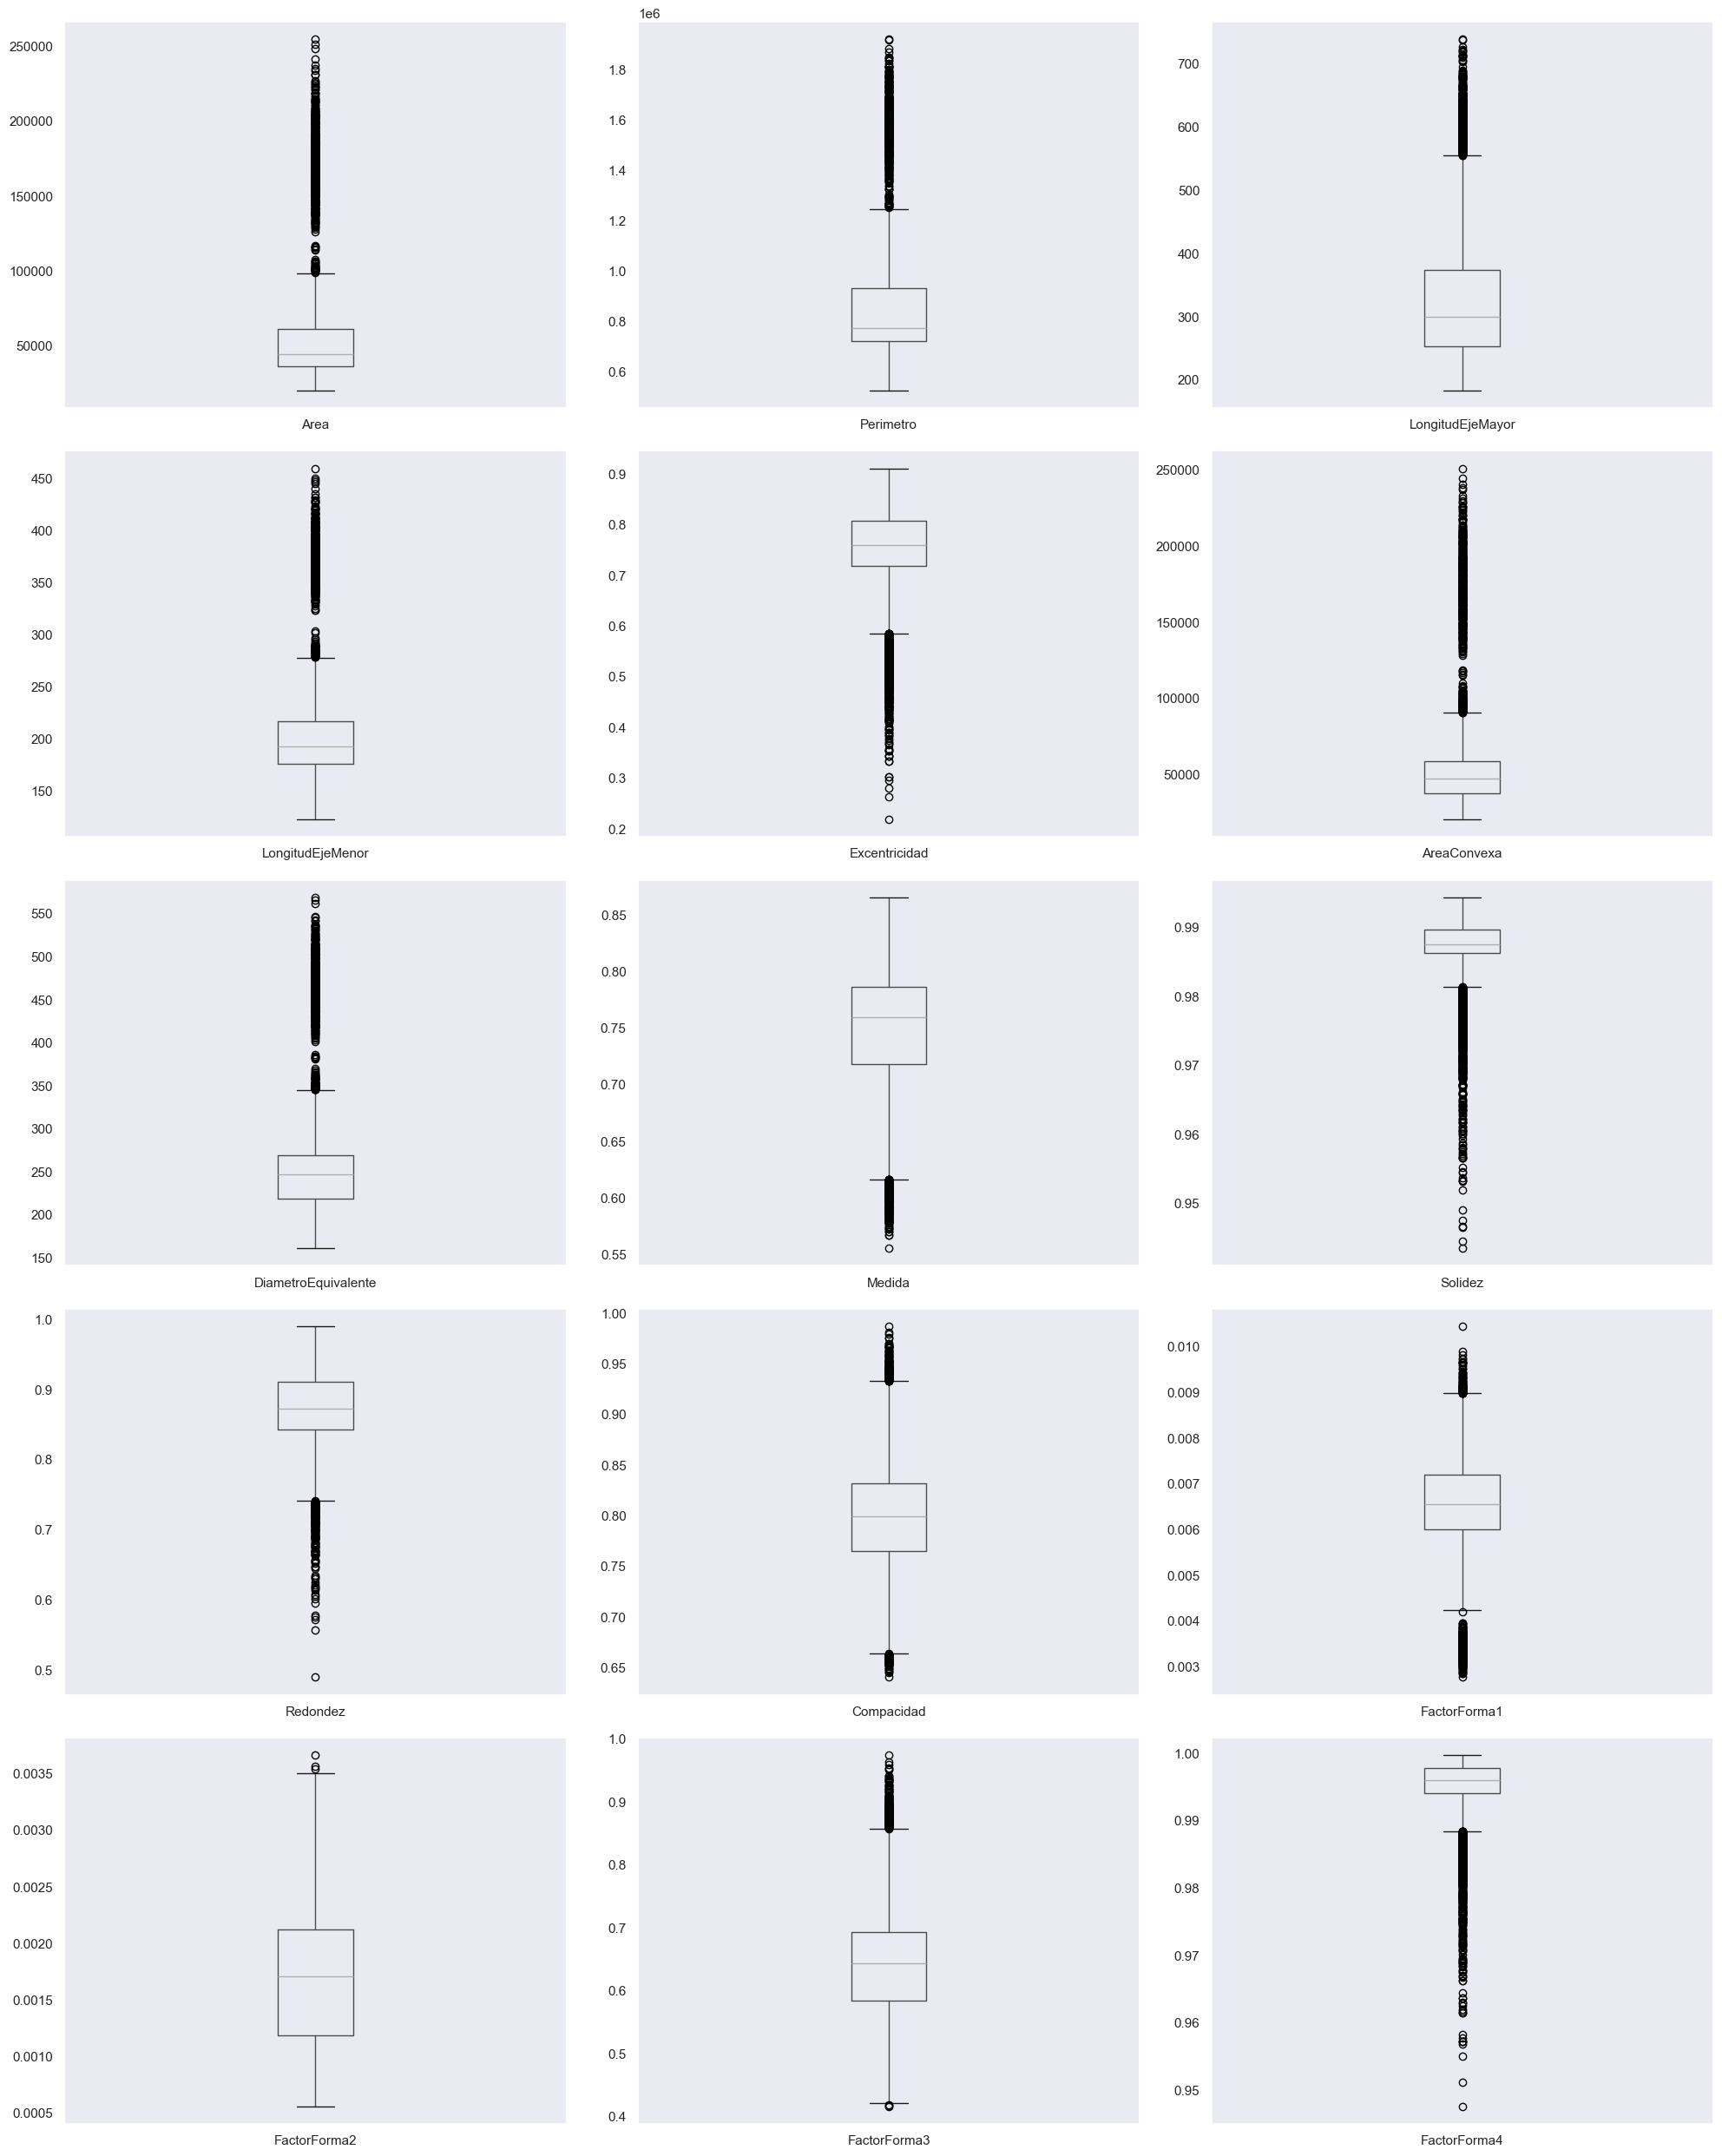

In [198]:
num_cols = len(numeric_cols)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 5 * 5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df_clean.boxplot(column=[col], ax=ax, grid=False)

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [199]:
# Eliminación de outliers
cols = [
    "Area",
    "Perimetro",
    "LongitudEjeMayor",
    "LongitudEjeMenor",
    "Excentricidad",
    "AreaConvexa",
    "DiametroEquivalente",
    "Medida",
    "Solidez",
    "Redondez",
    "Compacidad",
    "FactorForma1",
    "FactorForma3",
    "FactorForma4",
]

df_sin_outliers = df_clean.copy()

for col in cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    df_sin_outliers = df_sin_outliers[
        (df_sin_outliers[col] >= low) & (df_sin_outliers[col] <= high)
    ]

print("Shape original:", df_clean.shape)
print("Shape sin outliers:", df_sin_outliers.shape)

# df_clean = df_sin_outliers

Shape original: (13762, 21)
Shape sin outliers: (10409, 21)


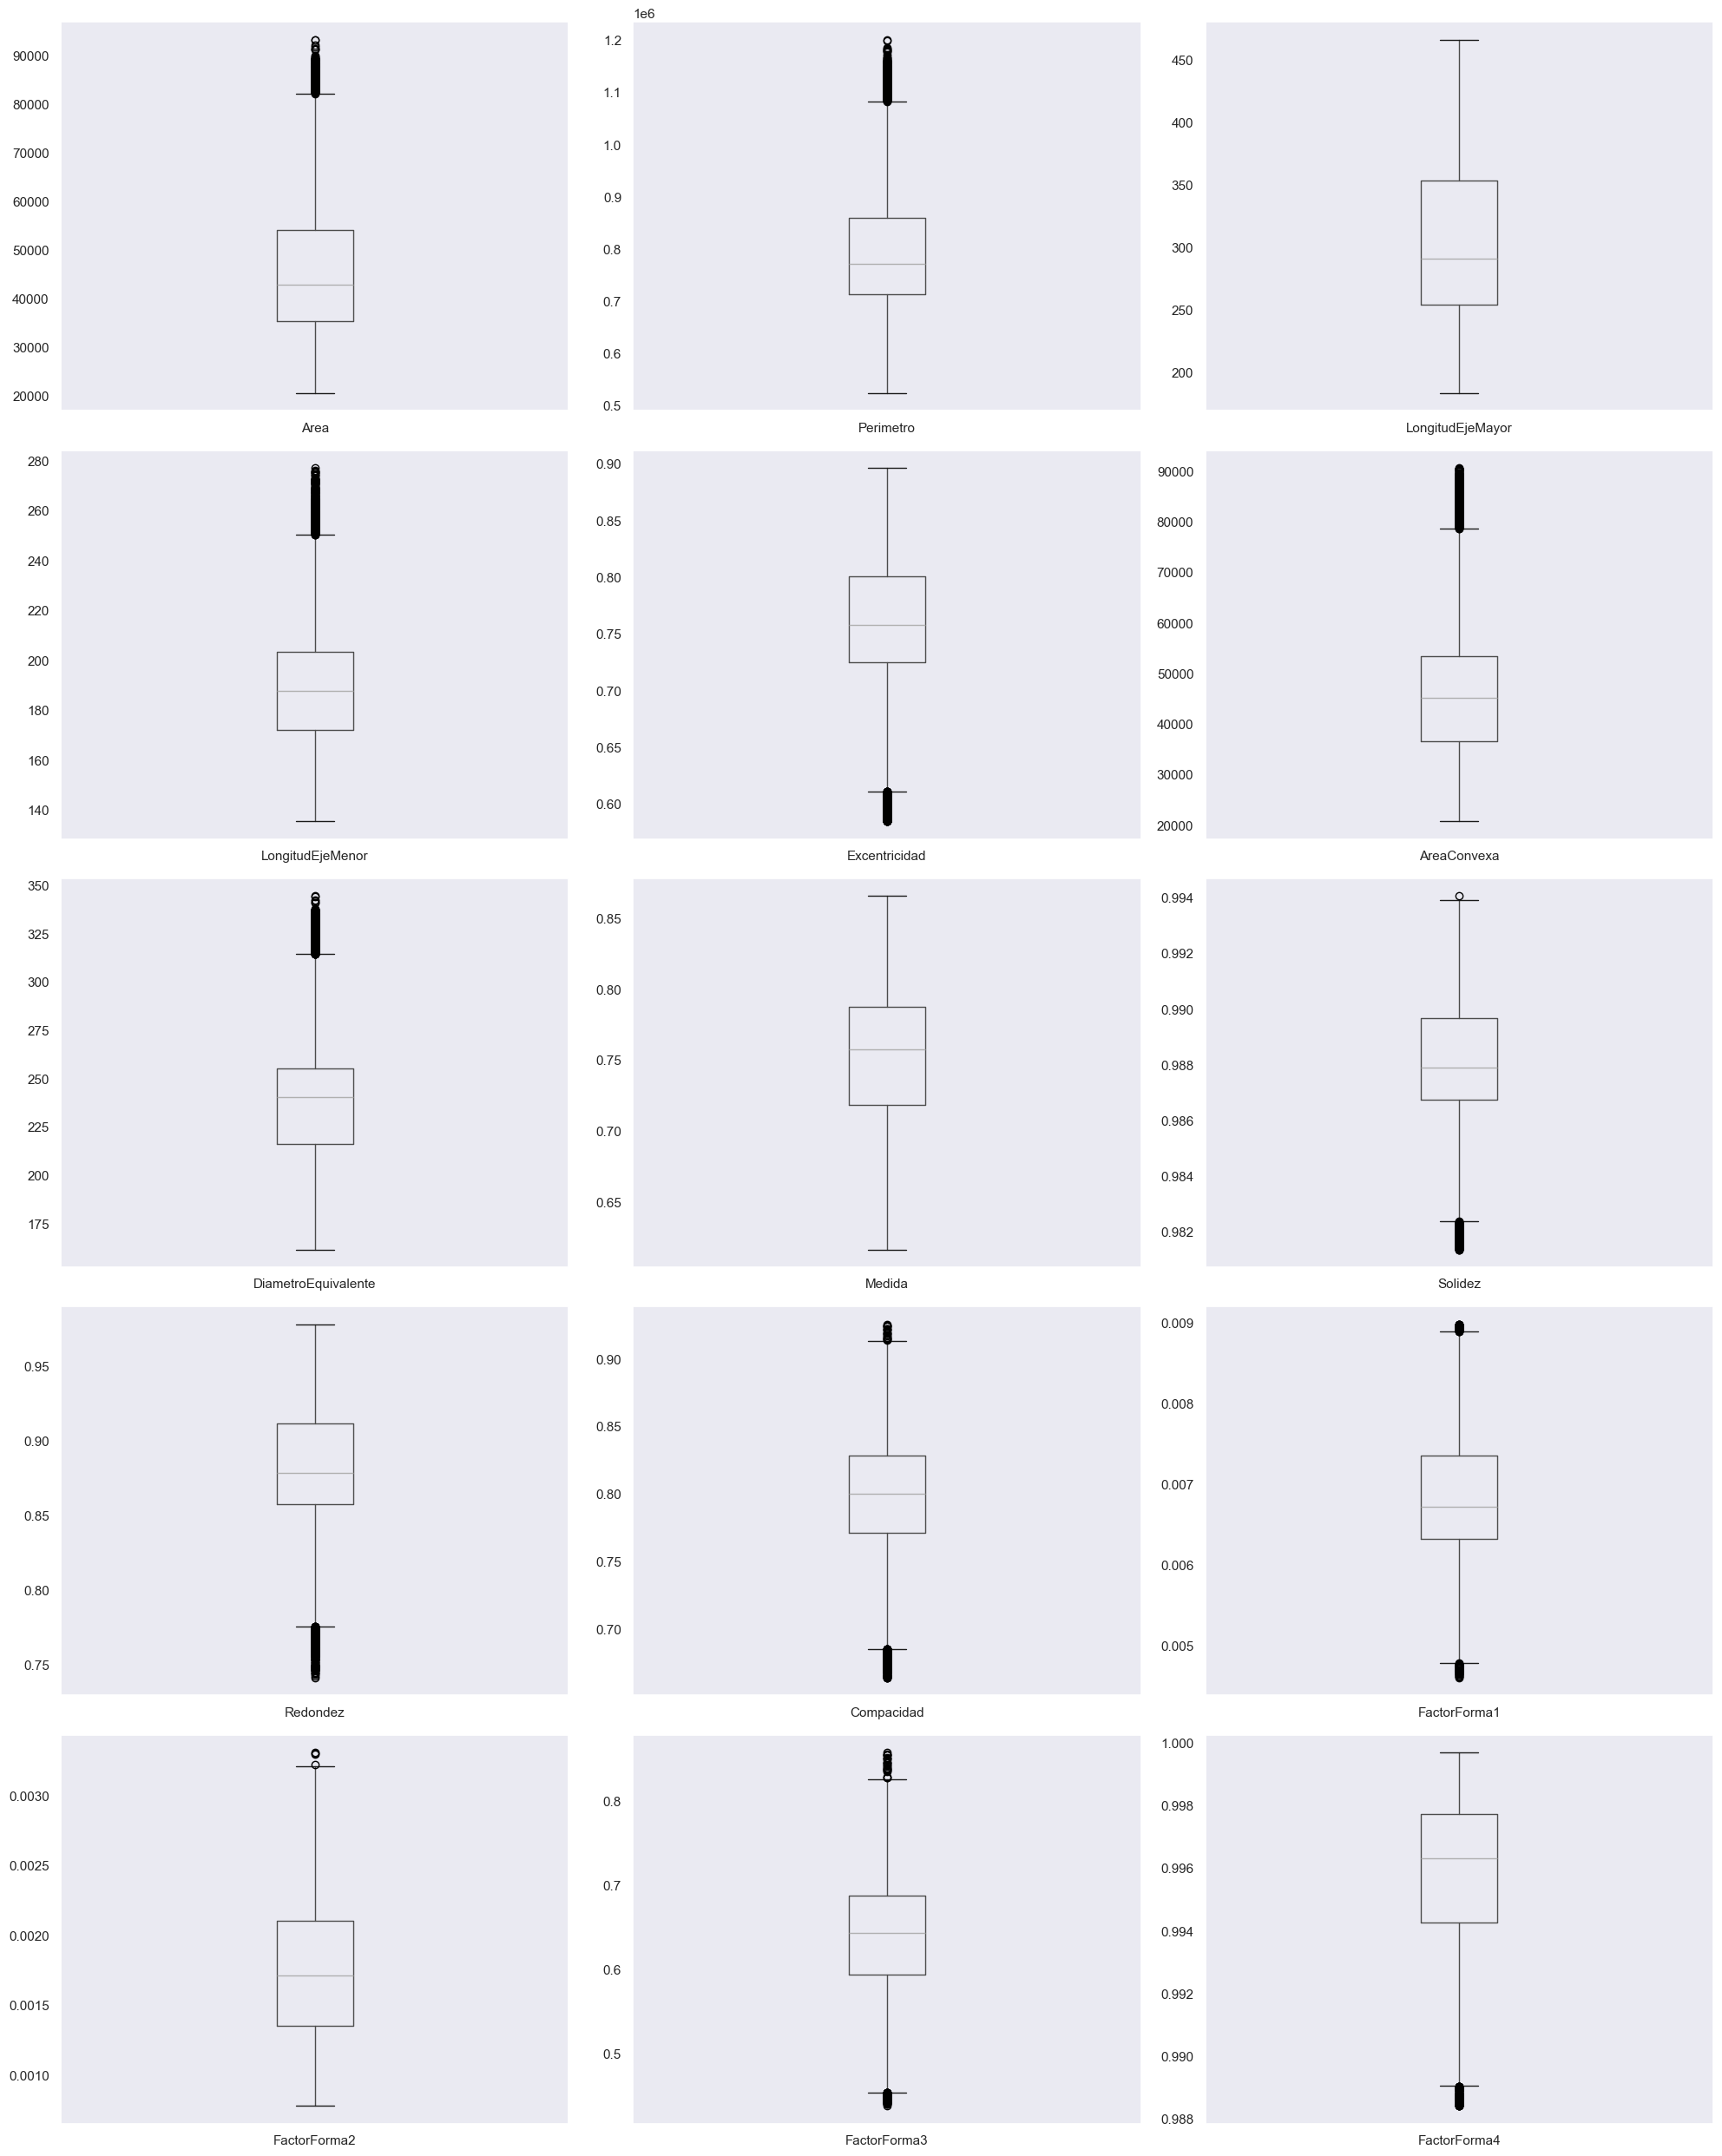

In [200]:
num_cols = len(df_sin_outliers.columns)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 5 * 5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df_sin_outliers.boxplot(column=[col], ax=ax, grid=False)

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Se realizó el ejercicio de eliminar outliers, pero al momento de experimentar con diferentes métodos se evaluó que esto hace que el desempeño empeore. Por lo que se presenta la gráfica de las distribuciones sin outliers, pero se utiliza el dataset con outliers para evitar eliminar información importante que introduzca sesgos al modelo.


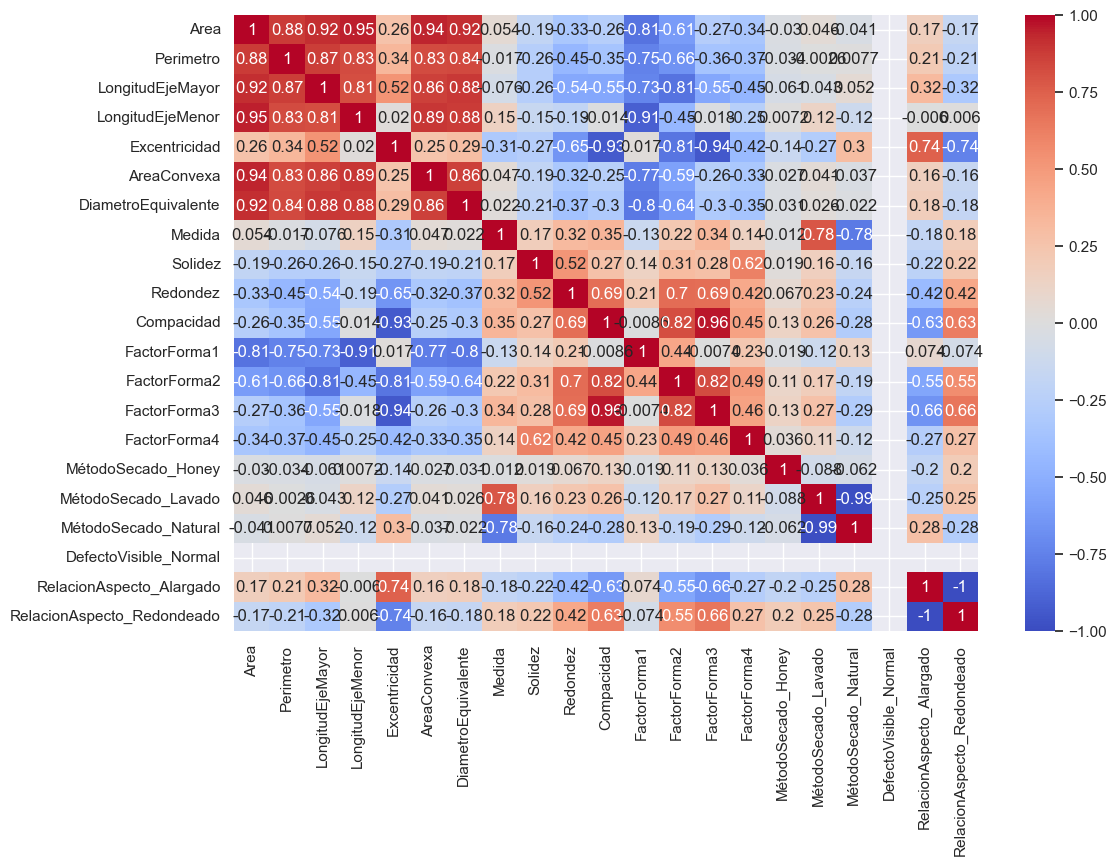

In [201]:
corr_matrix = df_clean.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.show()

A partir de la correlación entre atributos, se decide la importancia de estos para selecciónar cuales se mantienen. En primer lugar, se ve que `DefectoVisible` solo tiene 1 valor, así que se puede ignorar este atributo pues es solo ruido.

Siguiendo así, se puede ver que hay muchos atributos que estan fuertemente correlacionados, por lo que se pueden eliminar algunos. Para decidir cuales atributos eliminar se trato de evitar que se tuviera una correlación mayor a 0.8 y cuales fueron las columnas con mayor cantidad de datos imputados.


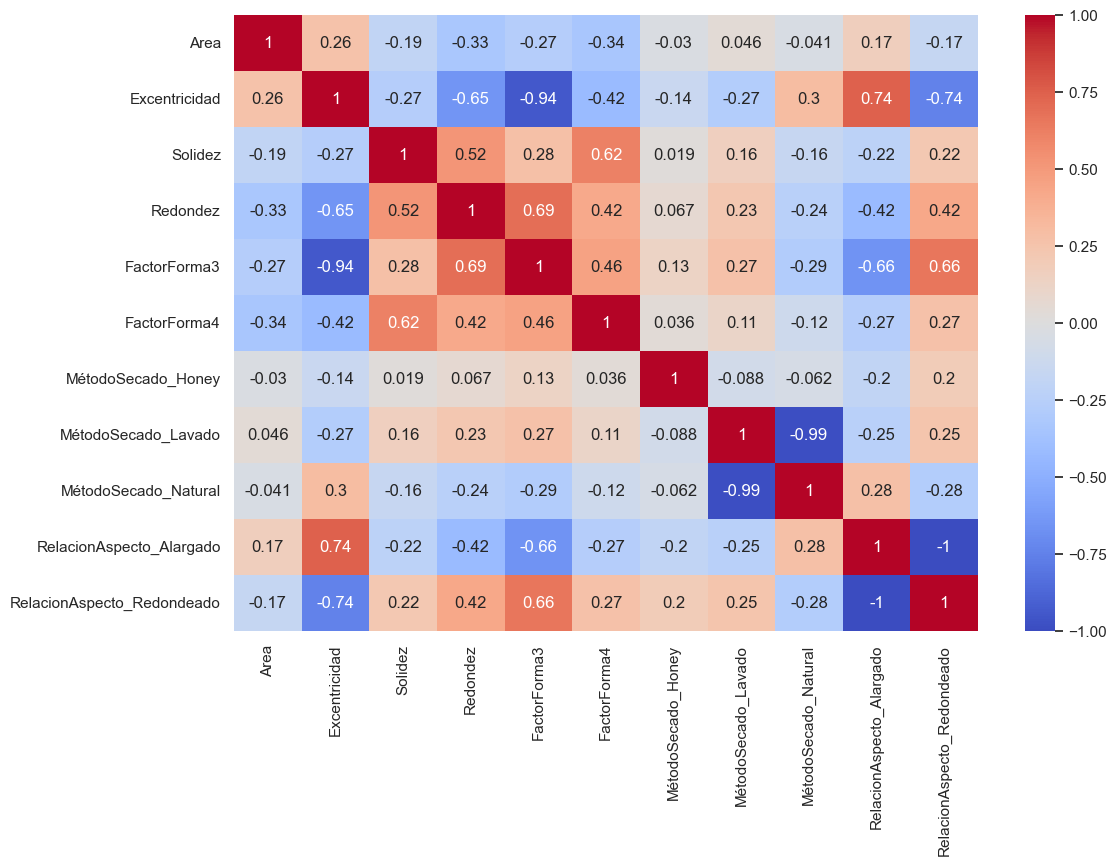

In [202]:
# df_clean = df_clean.drop(columns=['DefectoVisible_Normal', 'LongitudEjeMayor'] , axis=1)
df_clean = df_clean.drop(
    columns=[
        "DefectoVisible_Normal",
        "Perimetro",
        "AreaConvexa",
        "DiametroEquivalente",
        "LongitudEjeMenor",
        "LongitudEjeMayor",
        "Compacidad",
        "Medida",
        "FactorForma2",
        "FactorForma1",
    ],
    axis=1,
)
corr_matrix = df_clean.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.show()

Finalmente, se utilizó un MinMaxScaler para normalizar los datos debido a que estos tienen rangos muy diferentes entre columnas.
Con esto, se realiza una gráfica para identificar grupos naturales. Como se puede ver ya es evidente que se forman ciertos grupos por lo que el procesamiento de datos preliminar muestra resultados adecuados.


In [203]:
mms = MinMaxScaler()
df_prep = mms.fit_transform(df_clean)
df_norm = pd.DataFrame(df_prep, columns=df_clean.columns)
df_clean = df_norm

import pickle as pkl

with open("data.pkl", "wb") as f:
    pkl.dump(df_clean, f)

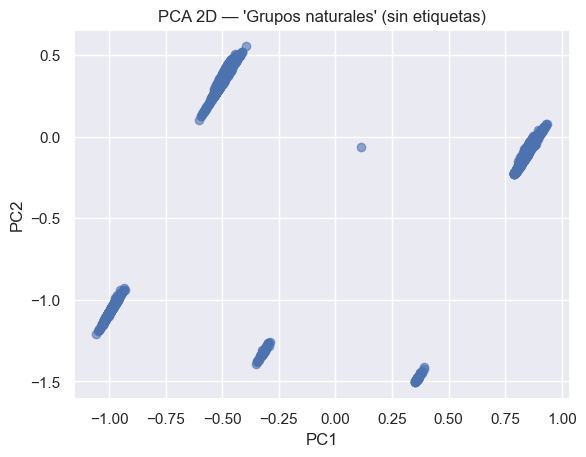

In [204]:
Xt = df_clean
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xt.toarray() if hasattr(Xt, "toarray") else Xt)

plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.6)
plt.title("PCA 2D — 'Grupos naturales' (sin etiquetas)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Conclusiones Entendimiento y Preparación de datos:

- Se revisó el dataset el cual originalmente contenía 14291 registros y 19 columnas. De las cuales se detectaron 4 columnas categóricas.
- Se revisó la calidad de los datos en donde se encontró que múltiples columnas tenían datos nulos. Estos se solucionaron con imputación de media para los numéricos e imputación de moda para los categóricos. Se analizó adicionalmente, que columnas se podían revisar para eliminar al tener porcentajes altos de datos nulos.
- Siguiendo con unicidad, se eliminaron los duplicados. Se tomó esta decisión ya que representan un porcentaje muy bajo dentro del dataset.
- Para consistencia, se ajustaron los valores de las columnas categóricas para que siguieran con las reglas impuestas en el diccionario.
- Finalmente, en cuanto a validez se ajustaron las columnas numéricas para que solo tengan valores positivos y respeten los rangos establecidos por definición del problema.
- Se analizaron las distribuciones de los datos después de limpiar los datos. Como hay muchos outliers se generó una limpieza con cuantiles. Sin embargo, se descartó ya que en la práctica esto elimina muchos datos significativos para el problema.
- En cuanto a selección de variables, se utilizó la correlación con lo que se eliminaron diferentes variables para garantizar correlaciones menores a 0.8 y mayores a -0.8.
- Se normalizaron los datos usando un MinMaxScaler y por último se generó una gráfica de grupos naturales con la que se revisó que se forman unos cuantos grupos.


# KMeans

Implementado por Laura Murcia


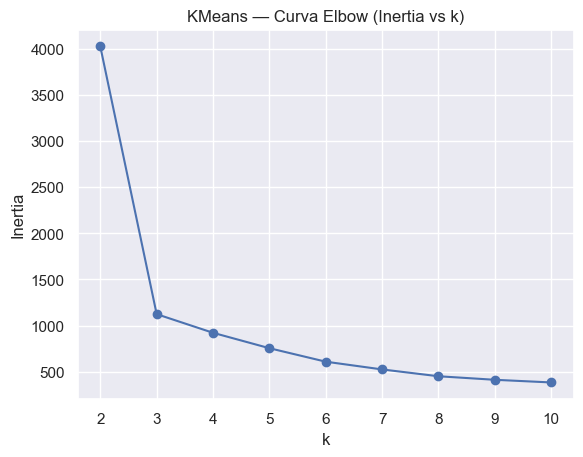

In [205]:
# Curva elbow para KMeans
df_kmeans = df_clean.copy()
inertias = []
ks = list(range(2, 11))
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df_kmeans)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(ks, inertias, marker="o")
plt.title("KMeans — Curva Elbow (Inertia vs k)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(ks)
plt.show()

In [206]:
def plot_distortion(
    data,
    k_min=1,
    k_max=11,
    ylabel="Distortion",
    xlabel="Number of clusters",
    title="Distortion Plot",
):

    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(
            n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0
        )
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min, k_max), distortions, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

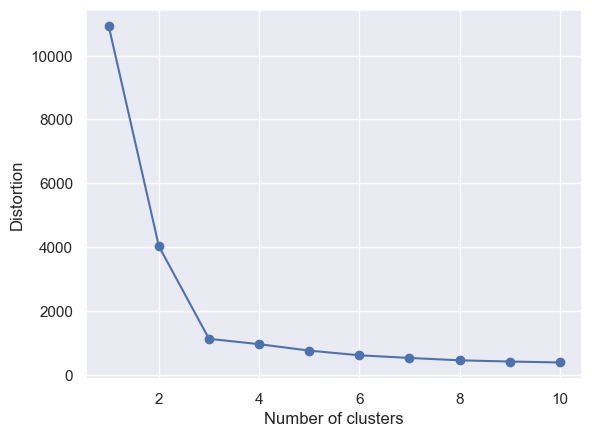

In [207]:
plot_distortion(df_kmeans, 1, 11)

In [208]:
def plot_silhouette(
    data,
    labels,
    ylabel="Grupos",
    xlabel="Coeficiente de silueta",
    title="Gráfica de silueta",
):
    cluster_labels = np.unique(labels)
    print(cluster_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data, labels, metric="euclidean")
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color,
        )
        yticks.append((y_ax_lower + y_ax_upper) / 2.0)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

Para el desarrollo de KMeans, uno de los parámetros de decisión más importante es el valor de k. Este determina en cuantos grupos se va a dividir los datos. Hay diferentes formas de estimar el valor de k, en este caso se utilizará el método de la curva del codo. A partir de la Curva del Codo de inercia y distorsión se puede determinar la cantidad de clusters que se deben realizar. Ambas gráficas indican que alrededor de 3 y 4 clusters es un número adecuado. Por esta razón, se construye el modelo con estas opciones y se analiza cual es la mejor.


### KMeans con 3 clusters


In [209]:
kmeans = KMeans(n_clusters=3, random_state=0)

res_kmeans = kmeans.fit(df_kmeans)

centroides3 = kmeans.cluster_centers_

<Axes: xlabel='Cluster'>

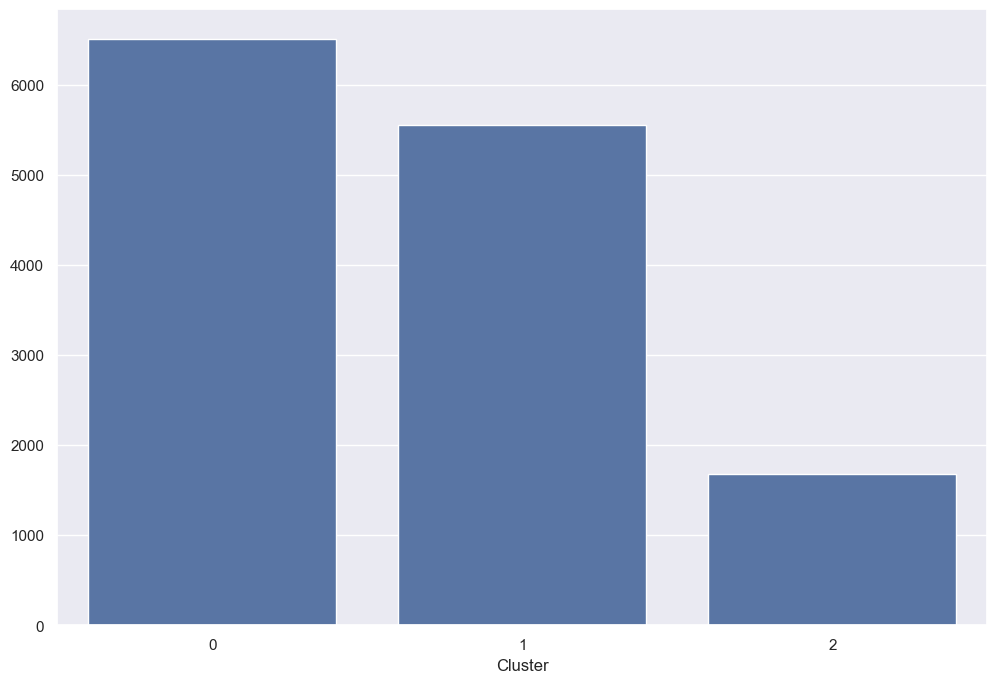

In [210]:
labels = res_kmeans.labels_
df_kmeans["Cluster"] = labels
cluster_distrib = df_kmeans["Cluster"].value_counts()
fig = plt.figure(figsize=(12, 8))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color="b")

Dentro de esta gráfica se puede ver la distribución de datos por cada cluster. Se puede ver de entrada que el cluster 2 es el que tiene menos datos asociados.


In [211]:
etiquetas = kmeans.fit_predict(df_kmeans)
sil_score = silhouette_score(df_kmeans, etiquetas)
sample_silhouette_values = silhouette_samples(df_kmeans, etiquetas)

print("Inertia:", kmeans.inertia_)
print("Silueta: ", sil_score)

Inertia: 1123.4885029368586
Silueta:  0.8202100815928818


Se calcula la silueta del problema con el fin de poder comparar más adelante las diferentes iteraciones.


[0 1 2]


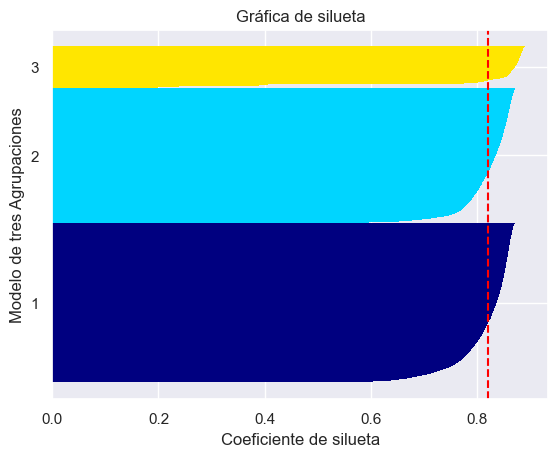

In [212]:
plot_silhouette(
    data=df_kmeans, labels=kmeans.labels_, ylabel="Modelo de tres Agrupaciones"
)

In [213]:
print(df_kmeans.shape)
print(len(centroides3[0]))

(13762, 12)
11


c:\Users\david\.conda\envs\bi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


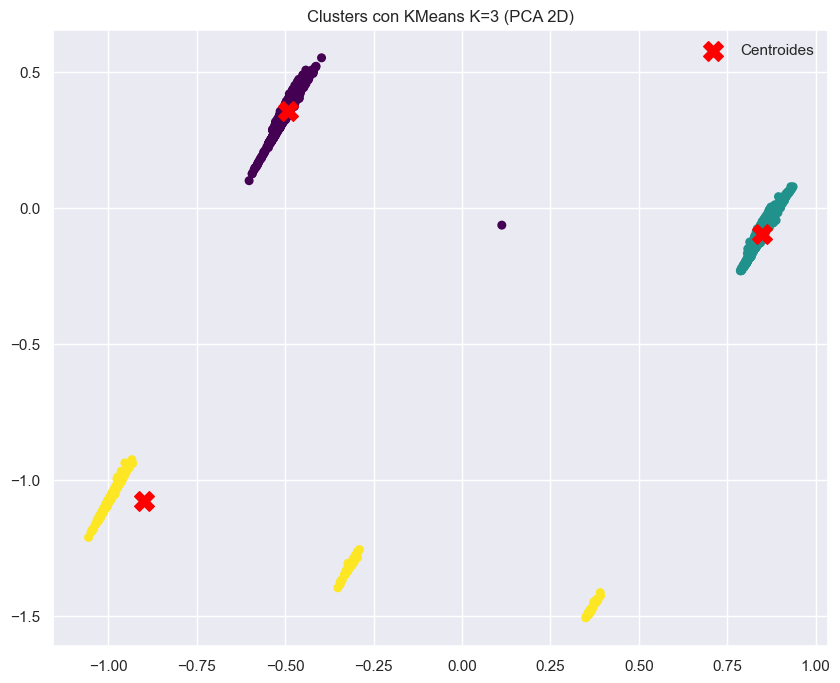

In [214]:
X_features = df_kmeans.drop(columns=["Cluster"])

# PCA solo con las features
pca = PCA(n_components=2)
Xc = pca.fit_transform(X_features)

centroides_proj = pca.transform(centroides3)

plt.figure(figsize=(10, 8))
plt.scatter(Xc[:, 0], Xc[:, 1], c=kmeans.labels_, s=30, cmap="viridis")

plt.scatter(
    centroides_proj[:, 0],
    centroides_proj[:, 1],
    c="red",
    marker="X",
    s=200,
    label="Centroides",
)

plt.legend()
plt.title("Clusters con KMeans K=3 (PCA 2D)")
plt.show()

In [215]:
df_kmeans = df_kmeans.drop(columns=["Cluster"])

### KMeans con 4 Clusters


<Axes: xlabel='Cluster'>

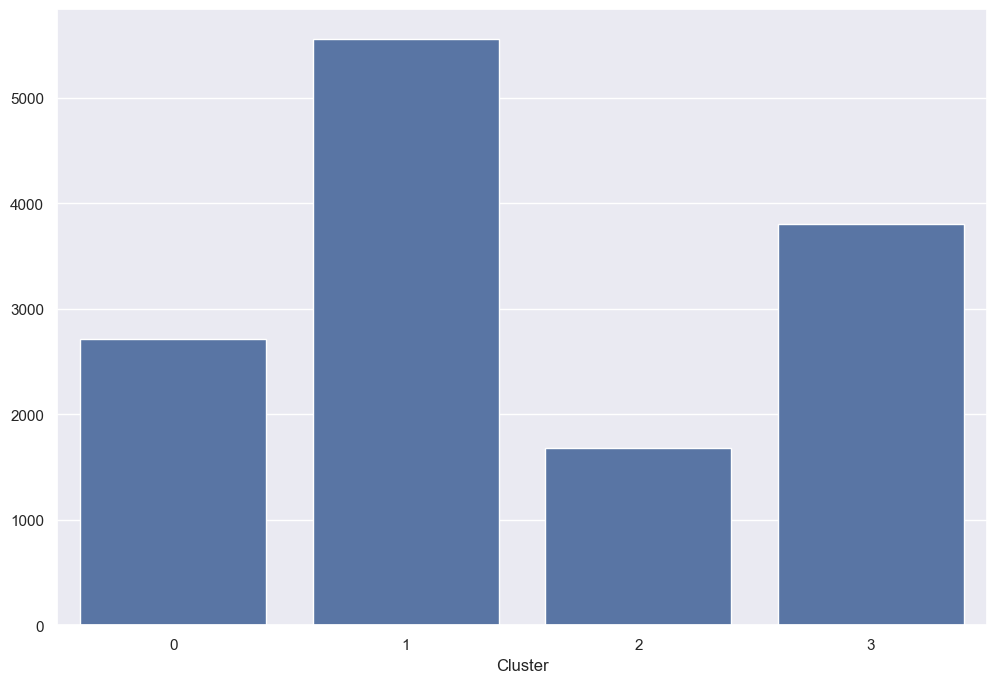

In [216]:
kmeans4 = KMeans(n_clusters=4, random_state=0)

res_kmeans4 = kmeans4.fit(df_kmeans)

centroides4 = kmeans4.cluster_centers_

labels4 = res_kmeans4.labels_
df_kmeans["Cluster"] = labels4
cluster_distrib4 = df_kmeans["Cluster"].value_counts()
fig = plt.figure(figsize=(12, 8))
sns.barplot(x=cluster_distrib4.index, y=cluster_distrib4.values, color="b")

In [217]:
etiquetas = kmeans4.fit_predict(df_kmeans)
sil_score = silhouette_score(df_kmeans, etiquetas)
sample_silhouette_values = silhouette_samples(df_kmeans, etiquetas)

print("Silueta: ", sil_score)
print("Inertia:", kmeans4.inertia_)

Silueta:  0.8369301712912793
Inertia: 956.4429329308279


[0 1 2 3]


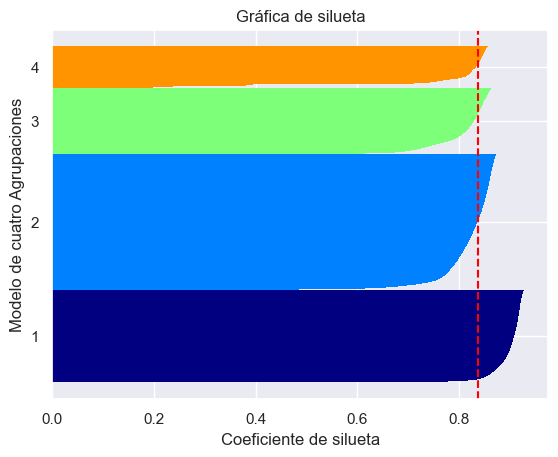

In [218]:
plot_silhouette(
    data=df_kmeans, labels=kmeans4.labels_, ylabel="Modelo de cuatro Agrupaciones"
)

c:\Users\david\.conda\envs\bi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


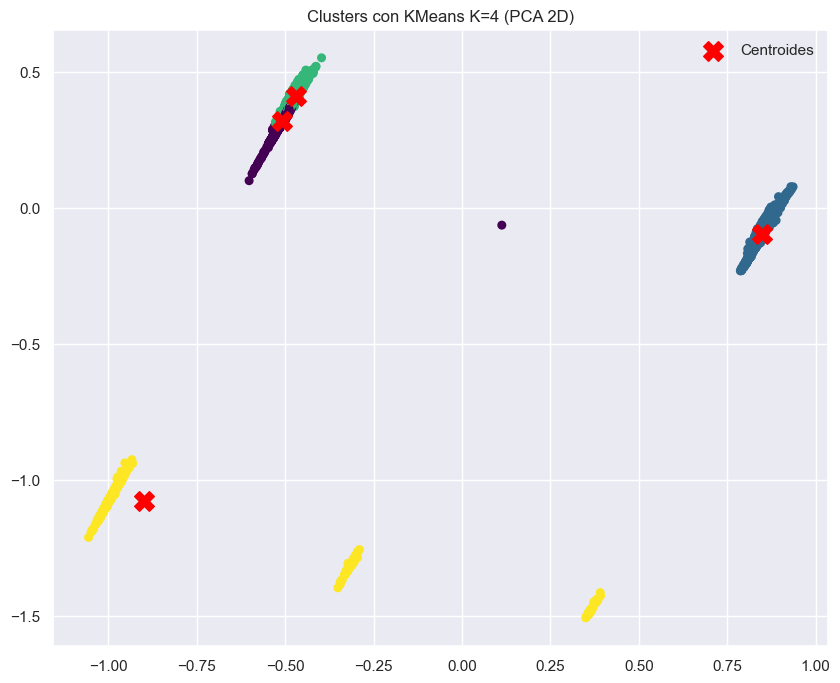

In [219]:
X_features = df_kmeans.drop(columns=["Cluster"])
# PCA solo con las features
pca = PCA(n_components=2)
Xc = pca.fit_transform(X_features)

centroides_proj = pca.transform(centroides4)

plt.figure(figsize=(10, 8))
plt.scatter(Xc[:, 0], Xc[:, 1], c=kmeans4.labels_, s=30, cmap="viridis")

plt.scatter(
    centroides_proj[:, 0],
    centroides_proj[:, 1],
    c="red",
    marker="X",
    s=200,
    label="Centroides",
)

plt.legend()
plt.title("Clusters con KMeans K=4 (PCA 2D)")
plt.show()

In [220]:
# df_kmeans = df_kmeans.drop(columns=['Cluster'])

### Análisis KMeans

Al realizar el análisis con 3 y 4 clusters, se puede ver que el mejor resultado se obtiene con 4 clusters.
El uso de k=4 permite tener una silueta de 0.837 lo que es altamente favorable para el problema. Adicionalmente, se tienen una inercia de 956.44 lo que denota que la distancia cuadrada del punto a su centroide es más baja que en el caso con 3 clusters.
A partir de las gráficas de distribución por cada cluster, tiene sentido que con 4 se tengan mejores resultados ya que se distribuyen de una forma un poco más equitativa todos los datos. Así mismo, al graficas la silueta para los diferentes grupos, se puede ver que todos llegan a superar el threshold de 0.8. Finalmente, se incluye una gráfica PCA en donde se reducen las features a 2 dimensiones con el objetivo de ver como se encuentran los datos con relación a los centroides, lo que deja ver que los grupos que se arman son adecuados.

### Resultados sobre KMeans k=4


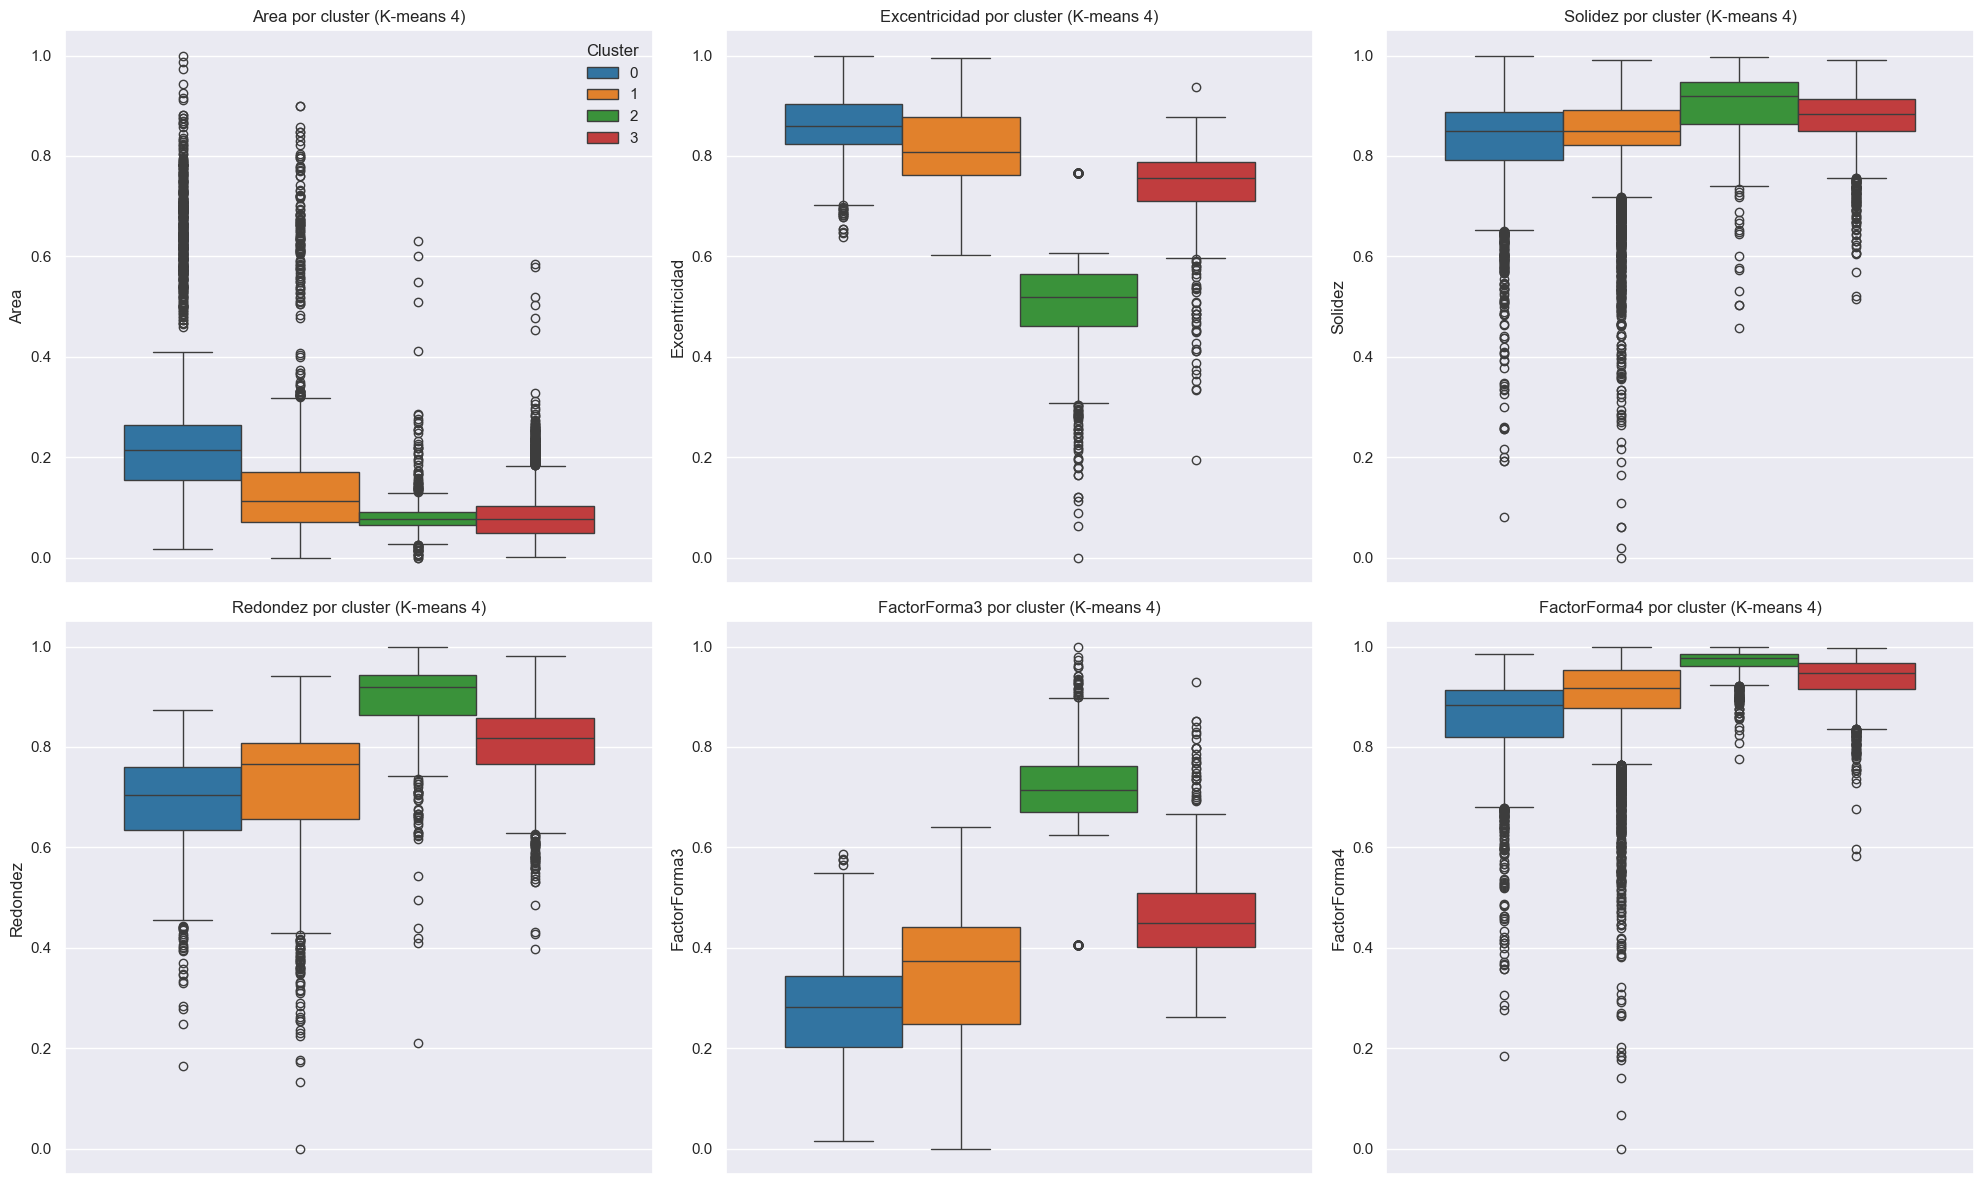

In [221]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

variables = [
    "Area",
    "Excentricidad",
    "Solidez",
    "Redondez",
    "FactorForma3",
    "FactorForma4",
]

for i, var in enumerate(variables):
    sns.boxplot(y=var, data=df_kmeans, ax=axes[i], hue="Cluster", palette="tab10")
    axes[i].set_title(f"{var} por cluster (K-means 4)")
    if i > 0:
        axes[i].get_legend().remove()

# fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

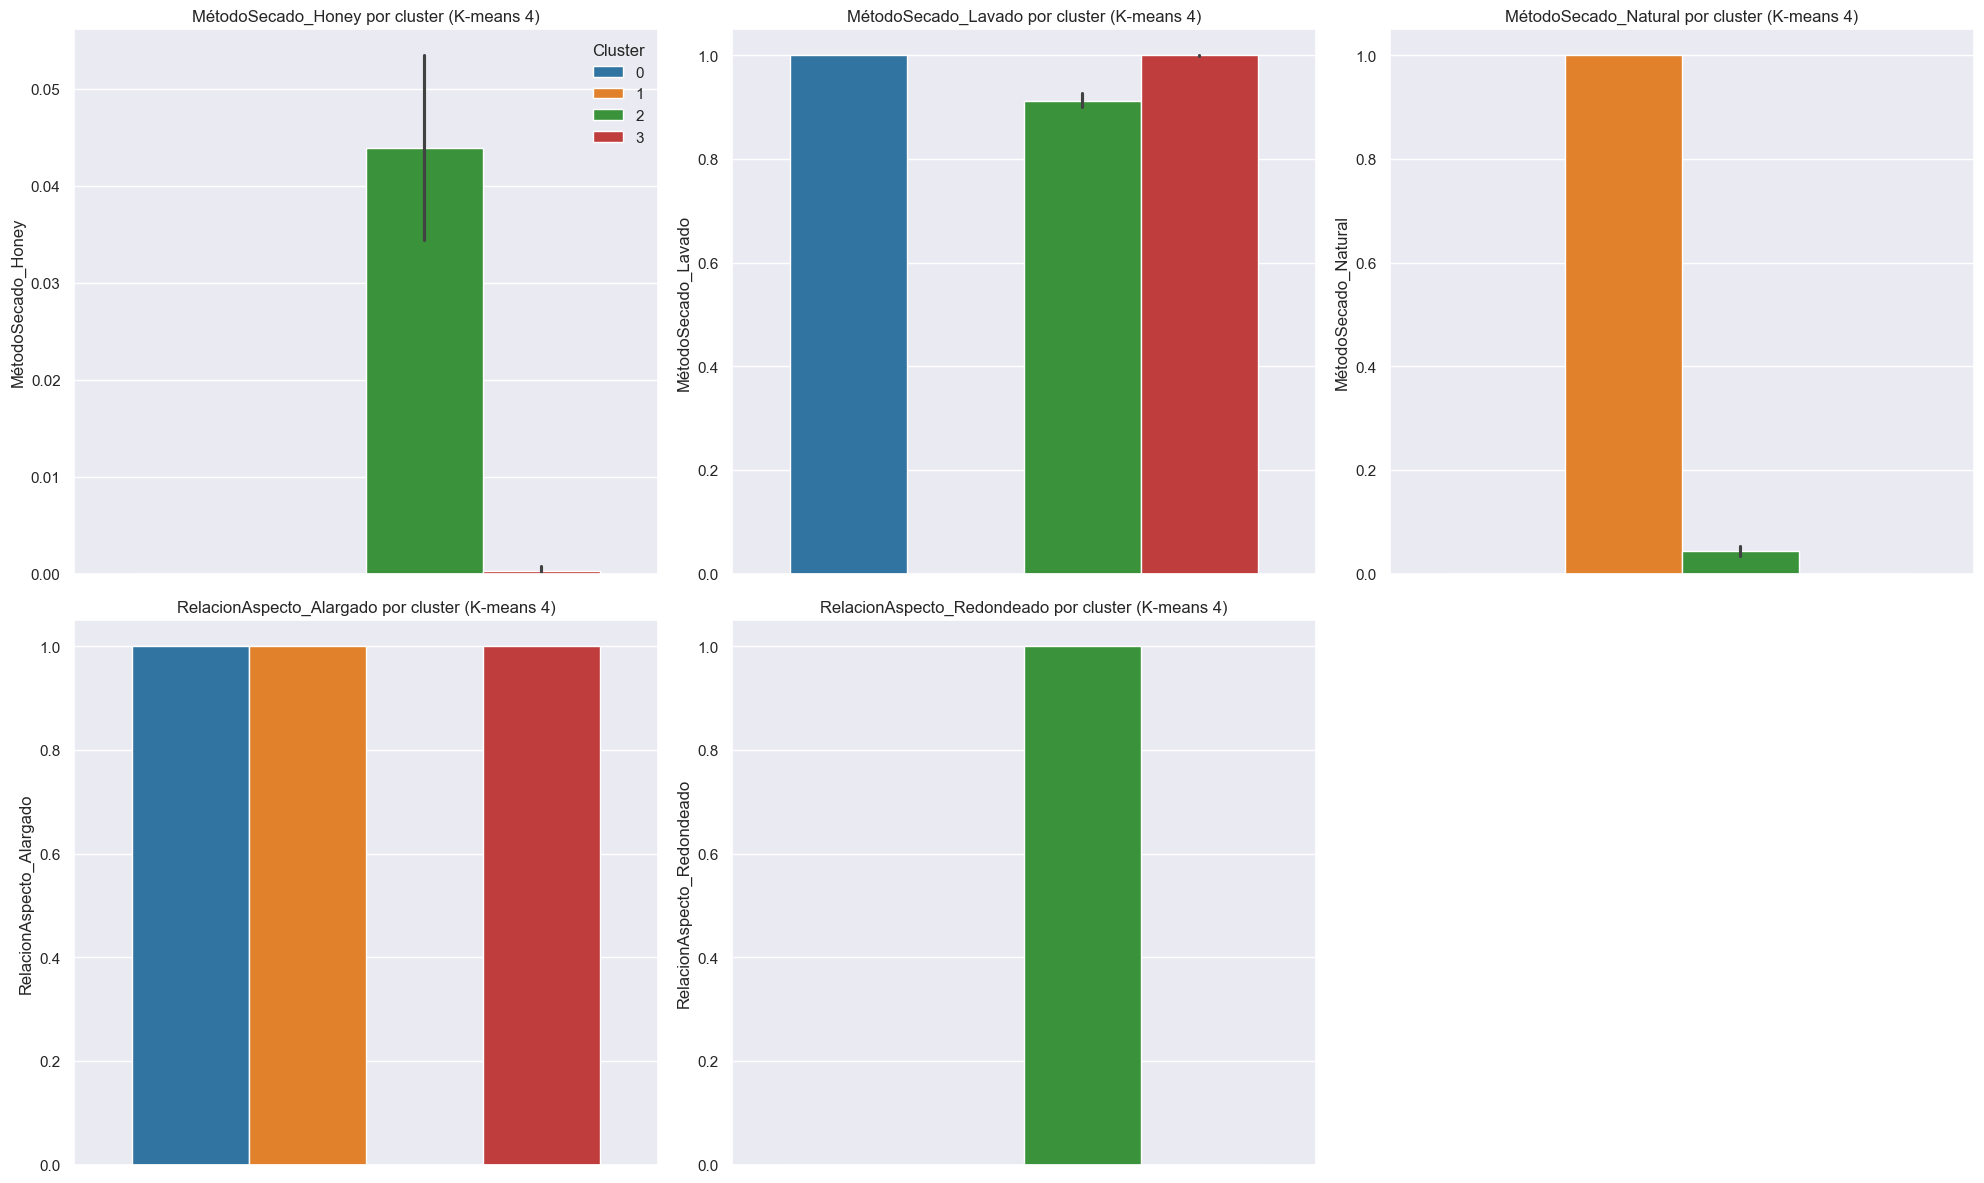

In [222]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

variables = [
    "MétodoSecado_Honey",
    "MétodoSecado_Lavado",
    "MétodoSecado_Natural",
    "RelacionAspecto_Alargado",
    "RelacionAspecto_Redondeado",
]

for i, var in enumerate(variables):
    sns.barplot(y=var, data=df_kmeans, ax=axes[i], hue="Cluster", palette="tab10")
    axes[i].set_title(f"{var} por cluster (K-means 4)")
    if i > 0:
        axes[i].get_legend().remove()

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

En la gráfica anterior se puede ver facilmente la distribución de datos por cluster. Como se puede ver en Area, Solidez, Redondez y FactorForma4 hay una cantidad elevada de outliers. Esta gráfica permite entender como las características se relacionan con los grupos, lo que aporta información a la empresa sobre que características hacen que los granos sean más similares entre sí.
Para visualizar datos numéricos se utilizan diagramas de caja y para datos categóricos se utilizan gráficas de barras para que sea más fácil ver.


De estos gráficos se puede observar:

- Método de secado: Hay clusters donde predominan métodos específicos (por ejemplo, algunos clusters tienen casi exclusivamente granos lavados o naturales). Esto indica que el método de secado es un factor relevante para la agrupación.
- Aspecto del grano: Los clusters también separan granos alargados y redondeados, lo que sugiere que la forma física es importante para la clasificación automática.
- Características físicas: Variables como área, excentricidad, solidez y redondez muestran diferencias claras entre clusters. Por ejemplo, algunos grupos tienen granos más redondeados y sólidos, mientras que otros presentan mayor excentricidad y menor área.


## DBSCAN

Implementado por Maria Alejandra Angulo

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de agrupamiento que identifica grupos de datos con alta densidad y separa puntos atípicos (ruido). No requiere especificar el número de clusters y es útil para descubrir patrones naturales en los datos, permitiendo clasificar automáticamente los granos de café según sus características morfológicas y de procesamiento.

Como no tiene en sus hiperparámetros una cantidad definida de clusters, se requiere de una elección inteligente del factor de la distancia para que el algoritmo reconozca en que premicias clasificar.


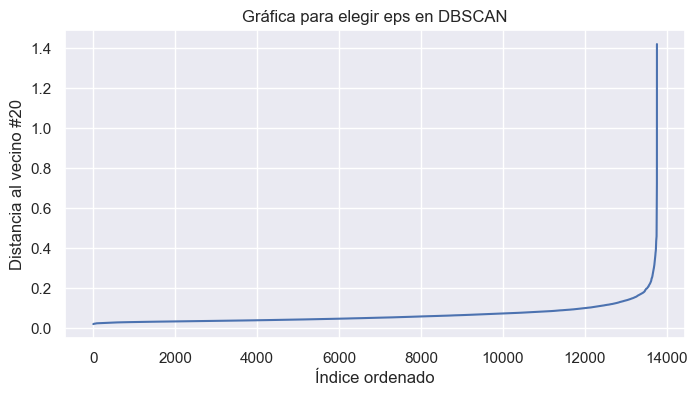

In [223]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_clean)
distances, indices = neighbors_fit.kneighbors(df_clean)
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.ylabel("Distancia al vecino #20")
plt.xlabel("Índice ordenado")
plt.title("Gráfica para elegir eps en DBSCAN")
plt.show()

Sobre esta gráfica es evidente que el esp mas apropiado es de 0.2 en adelante a 0.4 ya que antes de esta distancia al vecino, se agrupan puntos densos, mientras que después se incluyen puntos más dispersos, por lo que la mejor caracterización debe encontrarse sobre estos puntos. Para esto se hace la siguiente prueba que evalua diferentes eps


In [224]:
from sklearn.cluster import DBSCAN

for eps in [0.2, 0.3, 0.33, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1, 1.2, 3]:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(df_clean)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps={eps}: clusters={n_clusters}, ruido={n_noise}")

eps=0.2: clusters=6, ruido=70
eps=0.3: clusters=5, ruido=11
eps=0.33: clusters=5, ruido=7
eps=0.4: clusters=5, ruido=3
eps=0.45: clusters=5, ruido=2
eps=0.5: clusters=5, ruido=1
eps=0.55: clusters=5, ruido=1
eps=0.6: clusters=5, ruido=1
eps=0.8: clusters=5, ruido=1
eps=1: clusters=5, ruido=1
eps=1.2: clusters=5, ruido=1
eps=3: clusters=1, ruido=0


Se ve que el concenso general esta en la creación de 6 clusters (utilizando eps=0.2) o de 5 clusters utilizando un $eps\geq 0.3$. Para revisar cual de las 2 elecciones resulta mejor para este modelo. Se conserva 0.3 sobre el resto, ya que es la que es más coherente con la gráfica del codo presentada anteriormente.


### EPS=0.2


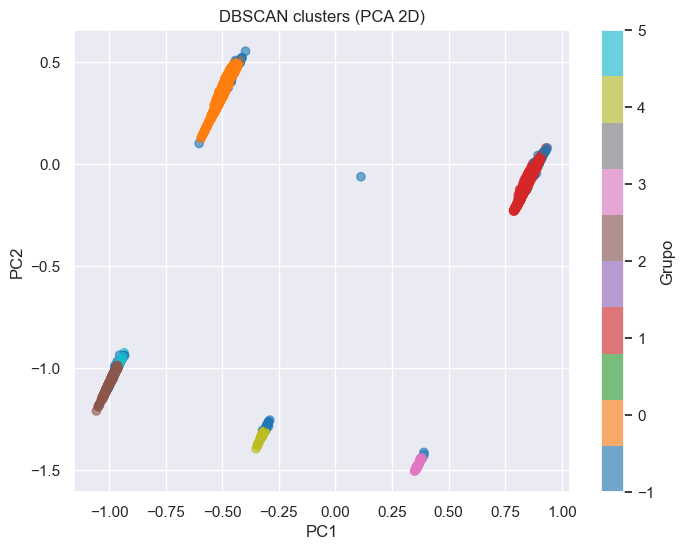

In [225]:
from sklearn.decomposition import PCA

dbscan = DBSCAN(eps=0.2, min_samples=20)
labels = dbscan.fit_predict(df_clean)

pca = PCA(n_components=2)
Z = pca.fit_transform(df_clean)
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("DBSCAN clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Grupo")
plt.show()

La gráfica de PCA 2D muestra que los granos de café se agrupan en diferentes regiones del espacio, lo que evidencia la existencia de patrones morfológicos distintos entre los clusters identificados por DBSCAN. Esto permite ver que cada grupo representa granos con características físicas similares, lo que facilita su clasificación automática y la estandarización de procesos.


In [226]:
from sklearn.metrics import silhouette_score

labels = dbscan.fit_predict(df_clean)
mask = labels != -1
if mask.sum() > 1 and len(set(labels[mask])) > 1:
    sil_score = silhouette_score(df_clean[mask], labels[mask])
    print(f"Coeficiente de silueta (sin ruido): {sil_score:.3f}")
else:
    print("No hay suficientes grupos para calcular silueta.")

Coeficiente de silueta (sin ruido): 0.753


### EPS=0.3


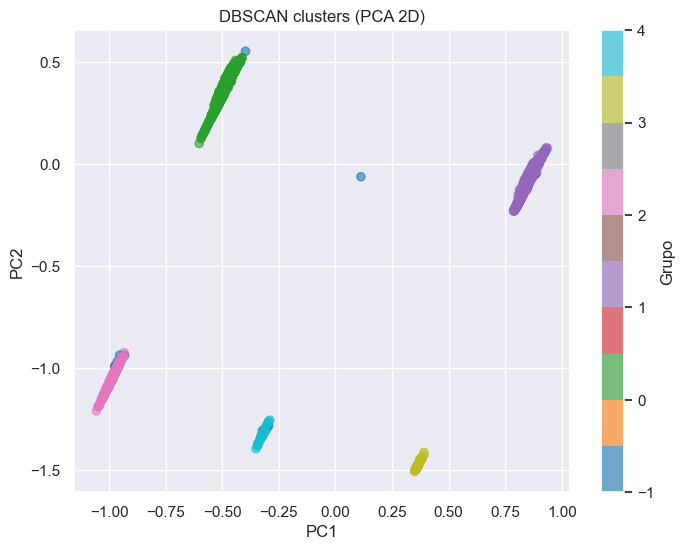

Coeficiente de silueta (sin ruido): 0.792


In [227]:
from sklearn.decomposition import PCA

dbscan = DBSCAN(eps=0.3, min_samples=25)  # Ajusta según el gráfico
labels = dbscan.fit_predict(df_clean)

pca = PCA(n_components=2)
Z = pca.fit_transform(df_clean)
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("DBSCAN clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Grupo")
plt.show()
from sklearn.metrics import silhouette_score

labels = dbscan.fit_predict(df_clean)
mask = labels != -1
if mask.sum() > 1 and len(set(labels[mask])) > 1:
    sil_score = silhouette_score(df_clean[mask], labels[mask])
    print(f"Coeficiente de silueta (sin ruido): {sil_score:.3f}")
else:
    print("No hay suficientes grupos para calcular silueta.")

Se evidencia que el coeficiente de silueta (sin ruido, ya que este considera a todos los outliers) es muy superior con un eps=0.3, donde el coeficiente de la silueta es 0.792 Esto implica una alta agrupación entre los clusters.

Asimismo, ya elegido el eps, se hacen pruebas para evaluar cual es la mejor muestra para entrenar el algoritmo


In [228]:
eps = 0.3
for min_samples in [5, 10, 15, 20, 25, 30, 40]:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df_clean)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(
        f"eps={eps}: clusters={n_clusters}, ruido={n_noise}, min_sample={min_samples}"
    )

    mask = labels != -1
    if mask.sum() > 1 and len(set(labels[mask])) > 1:
        sil_score = silhouette_score(df_clean[mask], labels[mask])
        print(f"Coeficiente de silueta (sin ruido): {sil_score:.3f}")
    else:
        print("No hay suficientes grupos para calcular silueta.")

eps=0.3: clusters=5, ruido=10, min_sample=5
Coeficiente de silueta (sin ruido): 0.792
eps=0.3: clusters=5, ruido=11, min_sample=10
Coeficiente de silueta (sin ruido): 0.792
eps=0.3: clusters=5, ruido=17, min_sample=15
Coeficiente de silueta (sin ruido): 0.792
eps=0.3: clusters=5, ruido=17, min_sample=20
Coeficiente de silueta (sin ruido): 0.792
eps=0.3: clusters=5, ruido=20, min_sample=25
Coeficiente de silueta (sin ruido): 0.792
eps=0.3: clusters=5, ruido=21, min_sample=30
Coeficiente de silueta (sin ruido): 0.792
eps=0.3: clusters=5, ruido=27, min_sample=40
Coeficiente de silueta (sin ruido): 0.793


Al hacer la prueba de muestras se evidencia que la elección distinta de este parametro no afecta los resultados, por lo que se sostiene el min_samples utilizado al comienzo para entrenar correctamente el modelo.

Asimismo, se hace una gráfica de silueta para ver la distribución de los grupos. Se presenta una versión modificada del plot original, ya que se desean ver los grupos omitiendo la clasificación el ruido.


In [229]:
def plot_silhouette_dbscan(
    data,
    labels,
    ylabel="Grupos",
    xlabel="Coeficiente de silueta",
    title="Gráfica de silueta DBSCAN",
):
    mask = labels != -1
    data_core = data[mask]
    labels_core = labels[mask]
    cluster_labels = np.unique(labels_core)
    print("Clusters encontrados (sin ruido):", cluster_labels)
    n_clusters = cluster_labels.shape[0]

    if n_clusters < 2:
        print("No hay suficientes clusters para graficar silueta.")
        return

    silhouette_vals = silhouette_samples(data_core, labels_core, metric="euclidean")
    cluster_sizes = [(c, np.sum(labels_core == c)) for c in cluster_labels]
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)

    total_samples = len(labels_core)
    min_cluster_size = min([size for _, size in cluster_sizes])

    base_space = max(50, min_cluster_size * 2)

    fig_height = max(8, n_clusters * 2)
    plt.figure(figsize=(12, fig_height))

    y_ax_lower = 0
    yticks = []

    for i, (c, size) in enumerate(cluster_sizes):
        c_silhouette_vals = silhouette_vals[labels_core == c]
        c_silhouette_vals.sort()
        y_ax_upper = y_ax_lower + size

        color = cm.viridis(float(i) / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color,
            label=f"Grupo {c}",
        )

        yticks.append((y_ax_lower + y_ax_upper) / 2.0)

        # Espaciado adaptativo: más espacio para clusters pequeños
        if size < total_samples * 0.05:
            space = base_space * 3
        else:
            space = base_space

        y_ax_lower = y_ax_upper + space

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--", linewidth=2)

    plt.yticks(yticks, [f"Grupo {c}" for c, _ in cluster_sizes], fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.show()

Clusters encontrados (sin ruido): [0 1 2 3 4]


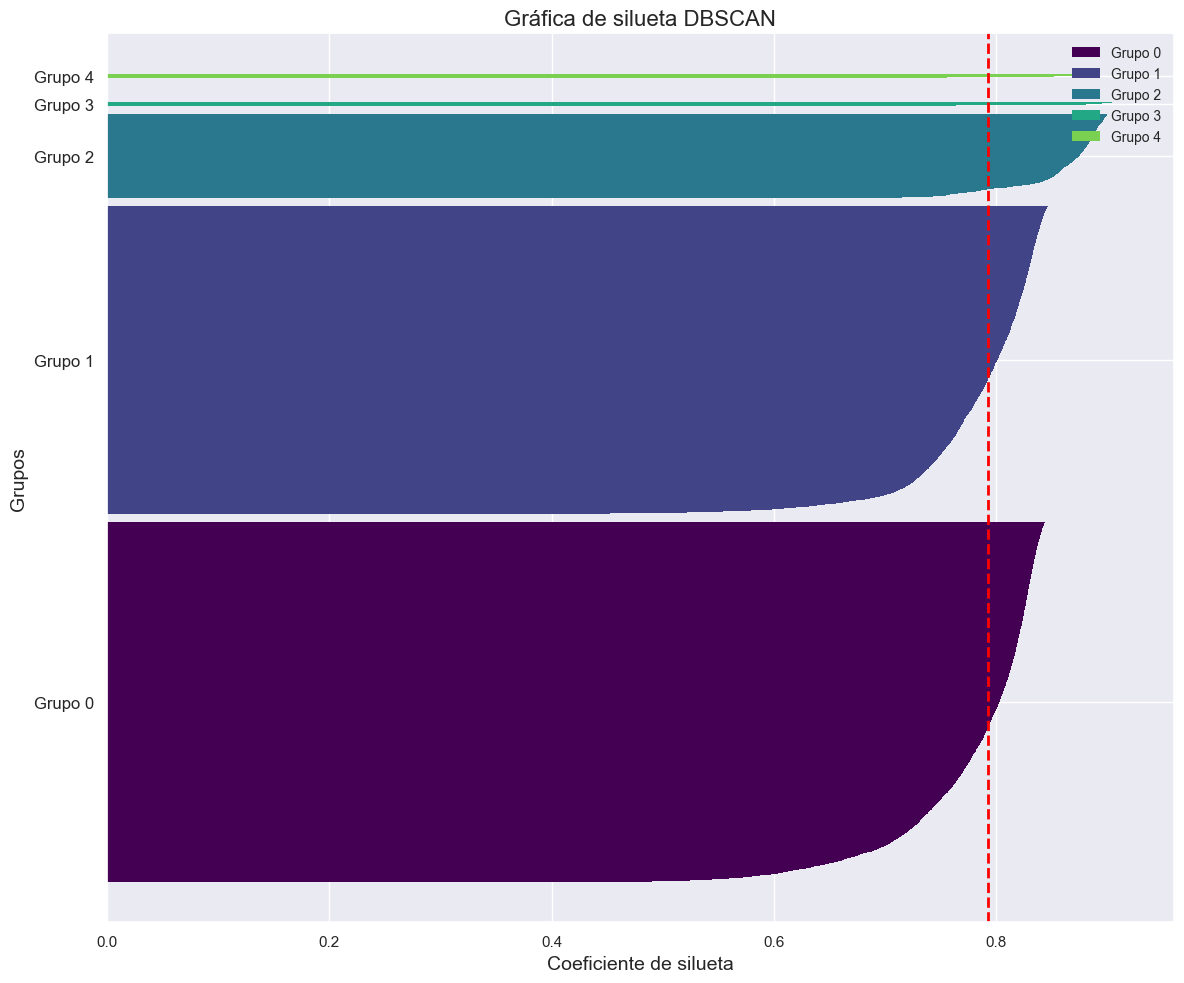

In [230]:
plot_silhouette_dbscan(df_clean.values, labels)

### Análisis DBSCAN

Después de las pruebas, se puede evidenciar que el mejor eps es 0.3, con una minima cantidad de muestras que es irrelevante ya que no afectan significativamente el resultado de la cantidad de clusters identificados. Asimismo, se evidencia un coeficiente de silueta de 0.79 que, aunque no es superior al de KMeans, muestra una alta agrupación entre los clusters.

Ya conociendo los 5 grupos (los outliers y los 4 identificados por el modelo), se puede hacer un entendimiento de dichas clases


In [231]:
df_clean["Cluster_dbscan"] = labels
cluster_summary = df_clean.groupby("Cluster_dbscan").mean()
display(cluster_summary)

,Area,Excentricidad,Solidez,Redondez,FactorForma3,FactorForma4,MétodoSecado_Honey,MétodoSecado_Lavado,MétodoSecado_Natural,RelacionAspecto_Alargado,RelacionAspecto_Redondeado
Cluster_dbscan,,,,,,,,,,,
-1,0.275757,0.753960,0.450929,0.566896,0.393968,0.616841,0.111111,0.481481,0.407407,0.740741,0.259259
0,0.158551,0.792973,0.857930,0.762484,0.381616,0.904694,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.133437,0.817206,0.840116,0.732593,0.343040,0.897983,0.000000,0.000000,1.000000,1.000000,0.000000
2,0.080424,0.504726,0.909050,0.893995,0.718502,0.968171,0.000000,1.000000,0.000000,0.000000,1.000000
3,0.080719,0.593615,0.875518,0.854398,0.654038,0.950406,0.000000,0.000000,1.000000,0.000000,1.000000
4,0.083997,0.517548,0.883334,0.871570,0.712280,0.949629,1.000000,0.000000,0.000000,0.000000,1.000000


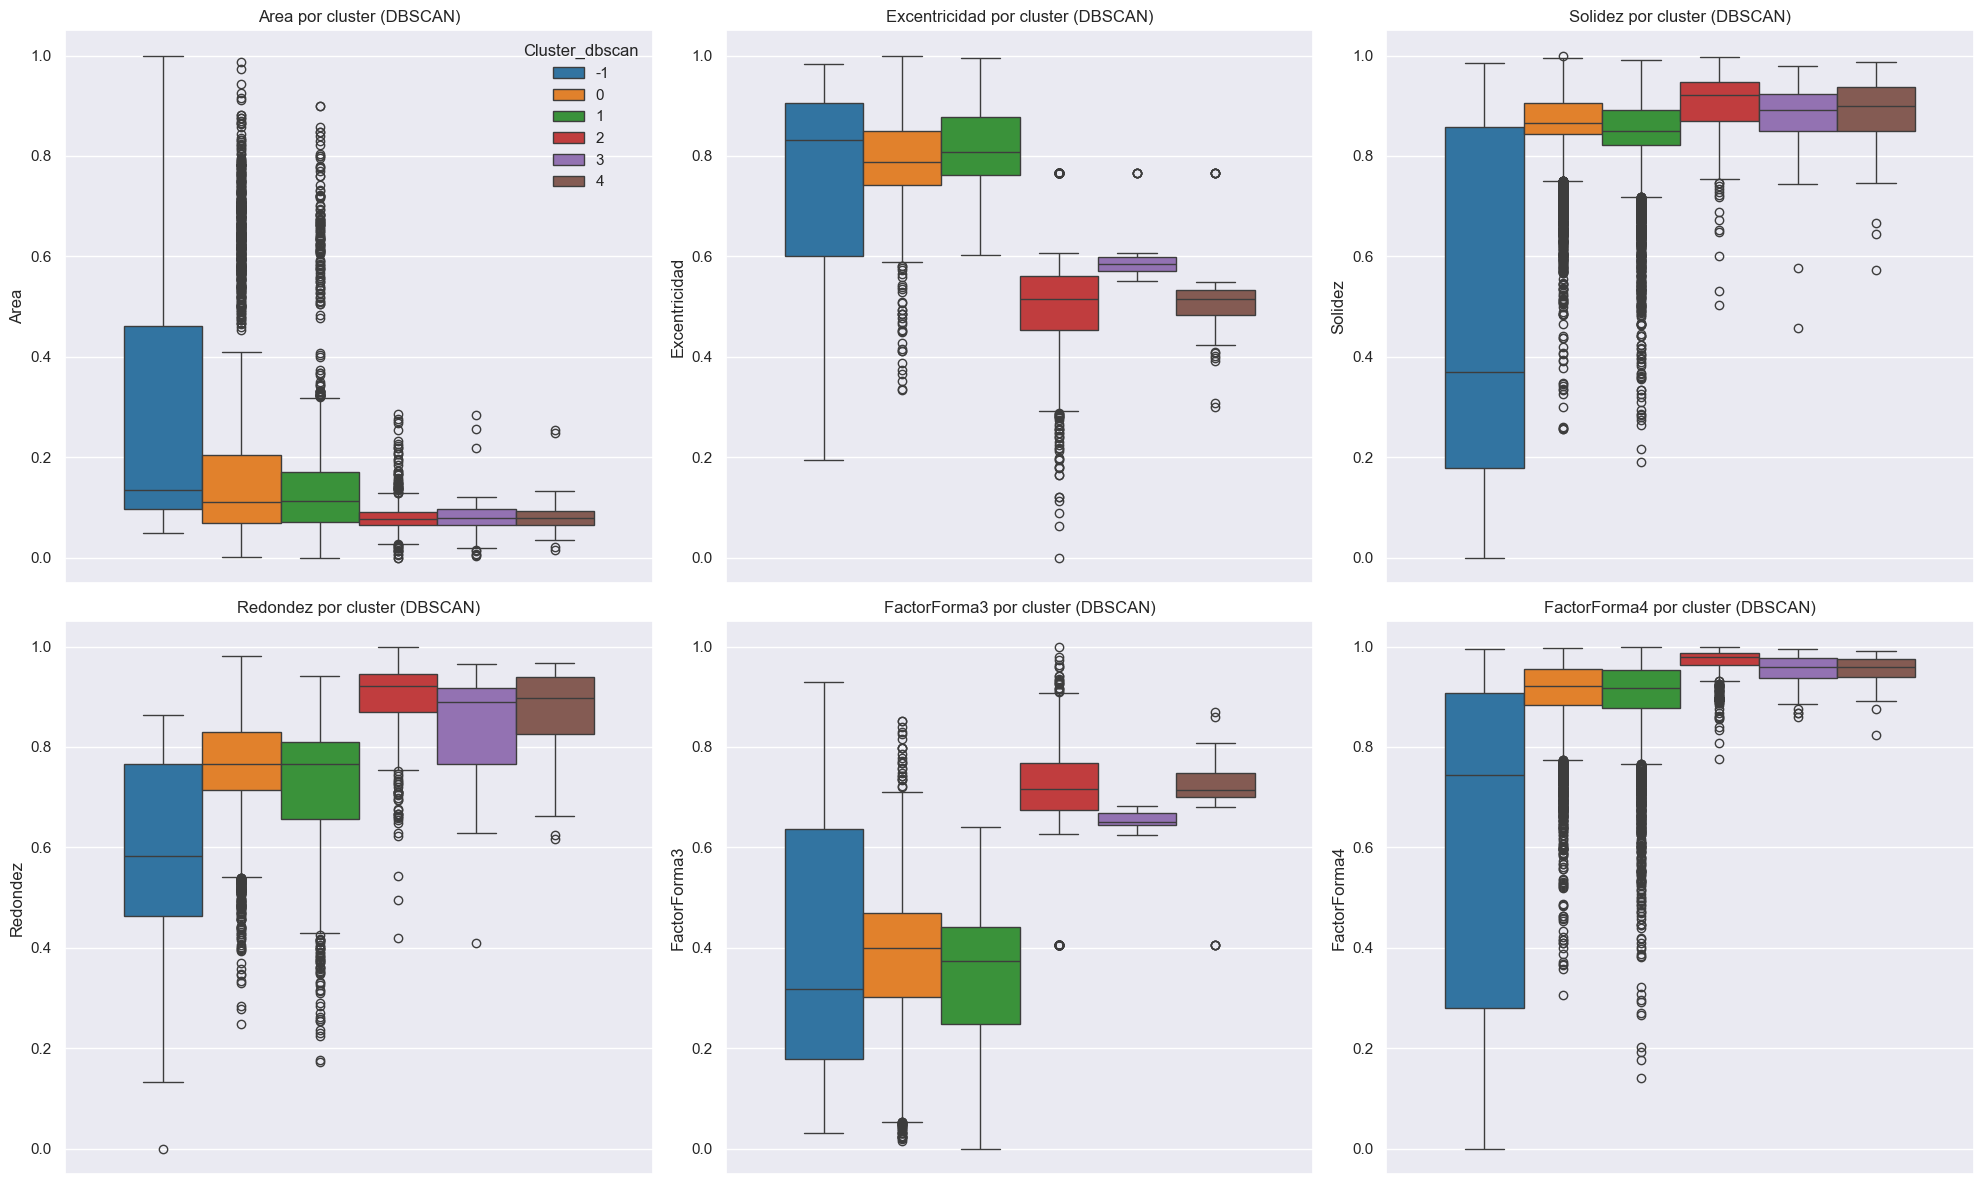

In [232]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

variables = [
    "Area",
    "Excentricidad",
    "Solidez",
    "Redondez",
    "FactorForma3",
    "FactorForma4",
]

for i, var in enumerate(variables):
    sns.boxplot(y=var, data=df_clean, ax=axes[i], hue="Cluster_dbscan", palette="tab10")
    axes[i].set_title(f"{var} por cluster (DBSCAN)")
    if i > 0:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

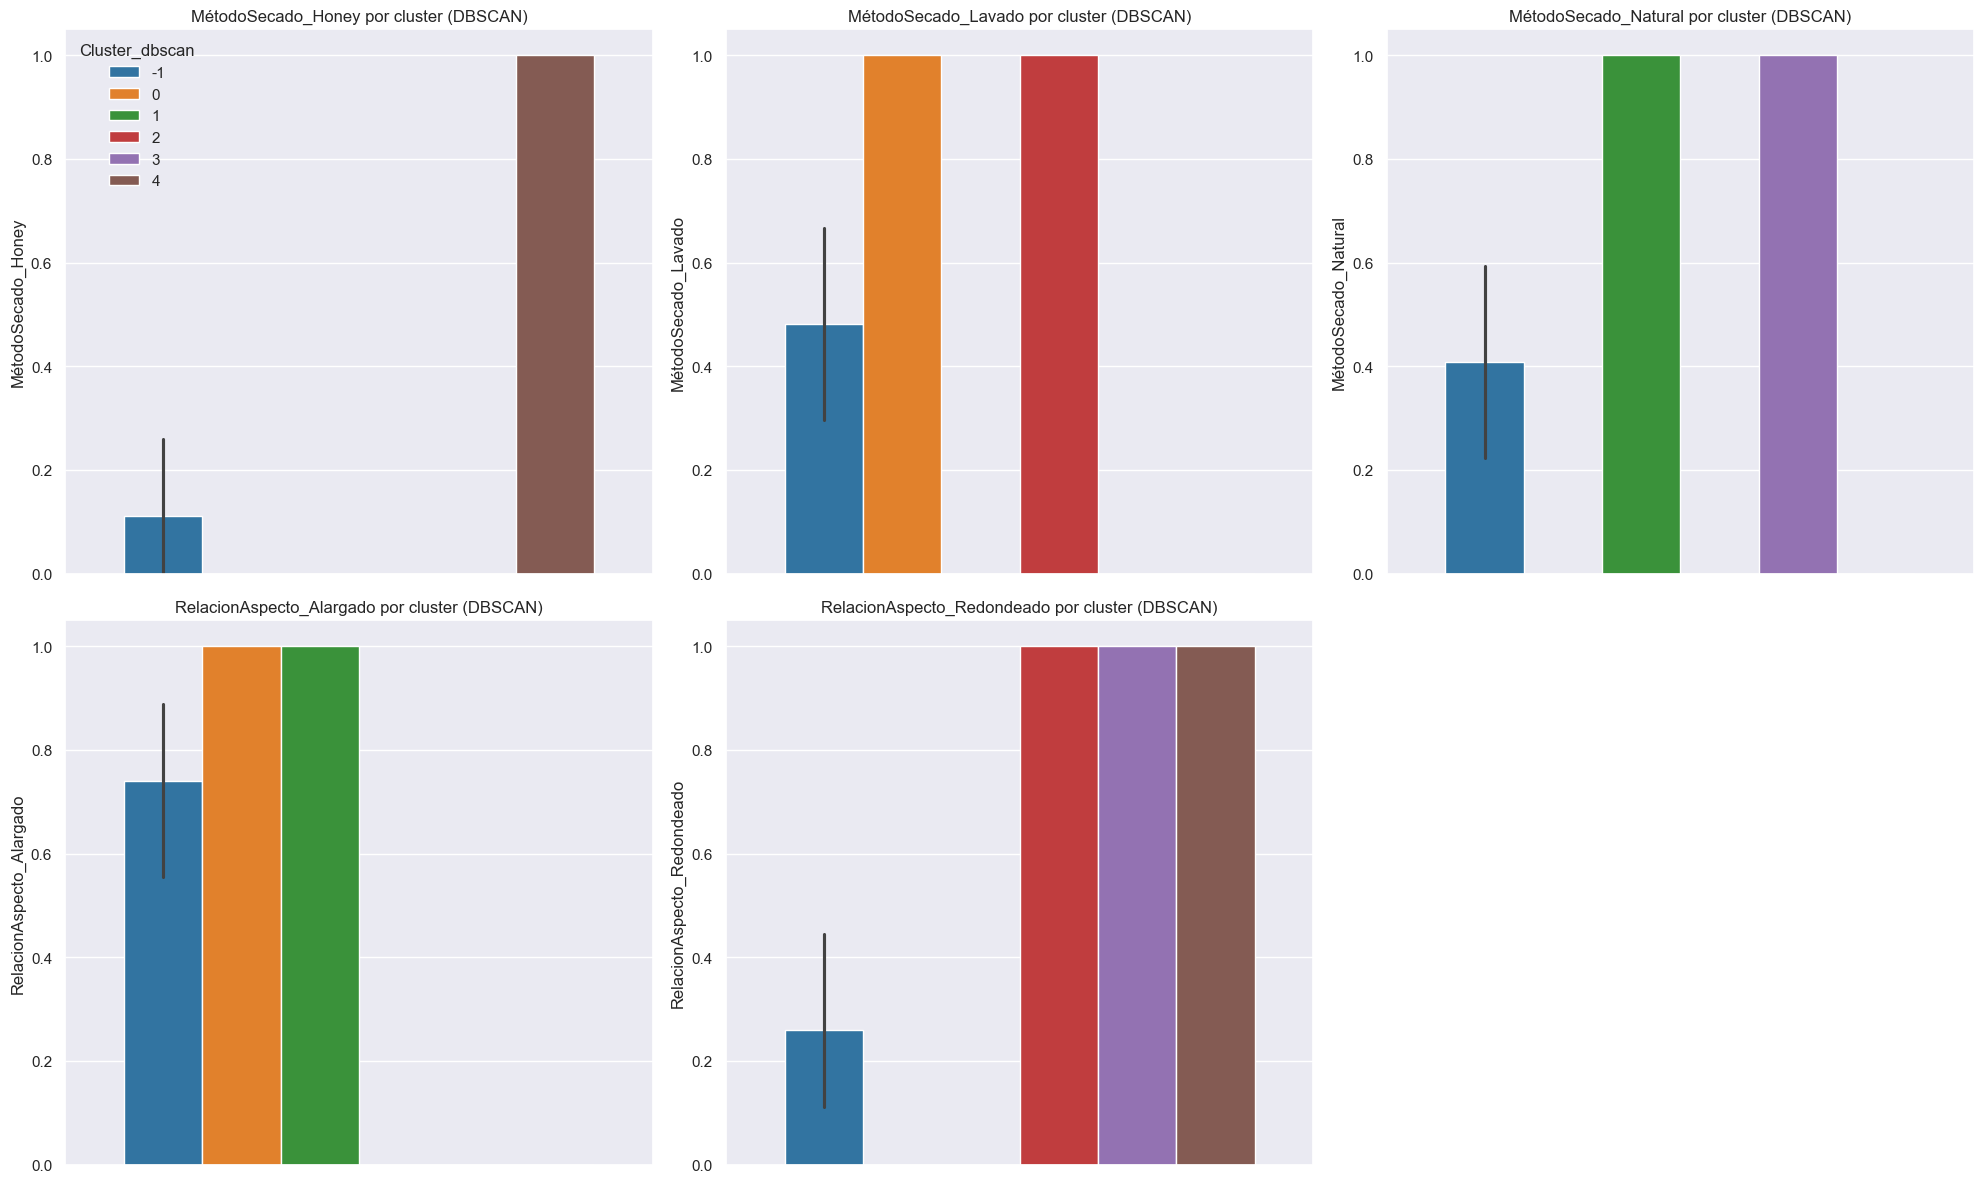

In [233]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

variables = [
    "MétodoSecado_Honey",
    "MétodoSecado_Lavado",
    "MétodoSecado_Natural",
    "RelacionAspecto_Alargado",
    "RelacionAspecto_Redondeado",
]

for i, var in enumerate(variables):
    sns.barplot(y=var, data=df_clean, ax=axes[i], hue="Cluster_dbscan", palette="tab10")
    axes[i].set_title(f"{var} por cluster (DBSCAN)")
    if i > 0:
        axes[i].get_legend().remove()

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Sobre estas diagramas se puede ver:

- Método de secado: Algunos clusters agrupan principalmente granos con métodos de secado específicos (por ejemplo, el cluster 4 tiene casi exclusivamente Honey, mientras que otros agrupan Lavado o Natural). Esto indica que el método de secado sigue siendo relevante para la agrupación.
- Aspecto del grano: Hay clusters donde predominan granos alargados y otros donde predominan redondeados, mostrando que la forma física sigue siendo importante para la clasificación.
- Características físicas: Los boxplots muestran que los clusters difieren en área, excentricidad, solidez y redondez. Algunos grupos tienen granos más sólidos y redondeados, mientras que otros presentan mayor excentricidad y menor área.
- Ruido: El cluster -1 agrupa los granos que no pertenecen a ningún grupo denso, es decir, posibles outliers o granos con características atípicas, lo que puede beneficiar el negocio.


# Clustering Aglomerativo

Implementado por David Tobón Molina

El Clustering Aglomerativo es un algoritmo de clustering jerárquico que sigue un enfoque bottom-up. Comienza tratando cada punto como un clúster individual y los fusiona progresivamente hasta que todos los puntos pertenecen a un único clúster. A diferencia de algoritmos como K-Means, no requiere que se especifique el número de clusters de antemano, aunque se puede especificar, ya que construye un árbol jerárquico (dendrograma) que puede ser "cortado" posteriormente para obtener el número deseado de clusters. Sus hiperparámetros clave son el linkage (criterio de enlace), el número de clusters (opcional) y la métrica de distancia utilizada.

Este método se basa en la fusión sucesiva de los clústeres más cercanos. En cada paso del algoritmo, se unen los dos clústeres que tienen la menor distancia entre ellos según una métrica de enlace definida. El resultado de este proceso es un _dendrograma_, que es una estructura de árbol que visualiza el orden y las distancias a las que se fusionaron los clústeres.

**Criterios de Enlace (Linkage):** La decisión de qué clústeres fusionar depende del criterio de enlace, que define cómo se mide la distancia entre dos clústeres. Los más comunes son:

- Ward: Minimiza la varianza dentro de los clústeres que se fusionan. Tiende a producir clústeres de tamaño similar. Es el método por defecto en muchas implementaciones y solo es compatible con la distancia euclidiana.

- Complete Linkage: Mide la distancia entre los dos puntos más lejanos de los dos clústeres.

- Average Linkage: Mide la distancia promedio entre todos los pares de puntos de los dos clústeres.

- Single Linkage: Mide la distancia entre los dos puntos más cercanos de los dos clústeres.

De todos modo, en conjuntos de datos grandes, el uso de diferentes criterios de enlace puede llevar a resultados similares, ya que la influencia de puntos individuales disminuye en comparación con la estructura global de los datos.

**Hiperparámetrs principales:**

- n_clusters: Especifica el número final de clusters que se desea obtener. El algoritmo se detendrá cuando se alcance este número, "cortando" el dendrograma en el nivel apropiado.

- linkage: El criterio utilizado para medir la distancia entre clústeres ('ward', 'complete', 'average', 'single'). La elección del linkage afecta significativamente la forma de los clusters resultantes.

- affinity: La métrica utilizada para calcular la distancia entre los puntos de datos individuales. Las más comunes son la distancia euclidiana, manhattan o coseno.


In [234]:
from sklearn.cluster import AgglomerativeClustering

with open("data.pkl", "rb") as f:
    X = pkl.load(f)

Se comparará la mejor combinación de hiperparámetros con los resultados obtenidos a partir del coeficiente de silueta, pues la inercia no es aplicable en este caso ya que los grupos obtenidos por este método no tienen un centroide definido.

Pero antes se visualizará un dendrograma, que es una visualización en forma de árbol de cómo se van fusionando los clústeres. La idea es buscar la línea vertical más larga que no cruce ninguna línea horizontal (fusión de clústeres). Esto representa la mayor "distancia" entre fusiones, sugiriendo un punto de corte natural.


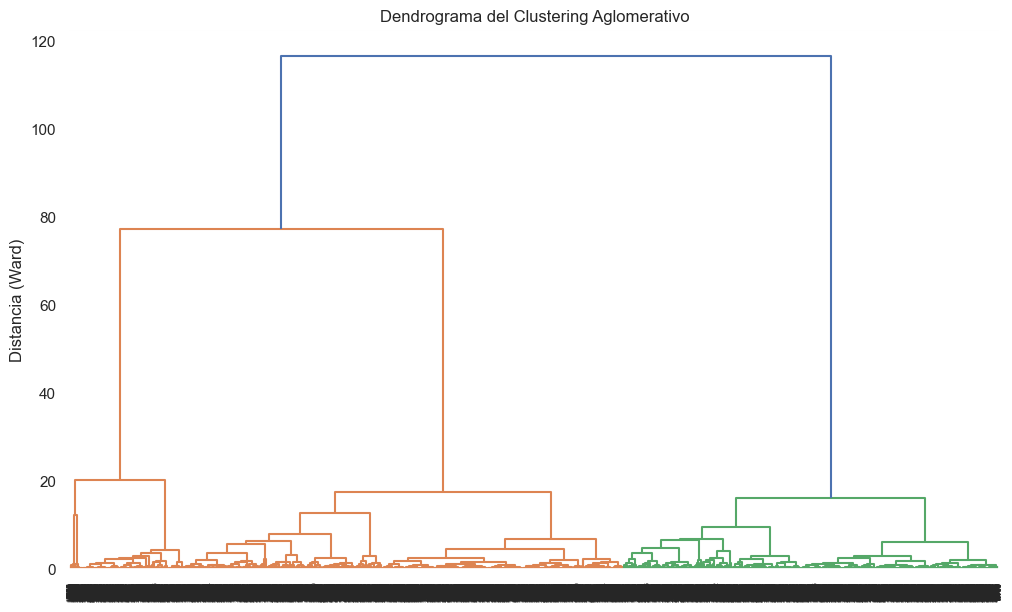

In [235]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, method="ward")

plt.figure(figsize=(12, 7))
dendrogram(linked, orientation="top", distance_sort="descending", show_leaf_counts=True)

plt.title("Dendrograma del Clustering Aglomerativo")
plt.ylabel("Distancia (Ward)")
plt.grid(axis="y")
plt.show()

El dendrograma muestra 3 líneas verticales largas que no cruzan ninguna línea horizontal, lo que sugiere que cortar el dendrograma en estos puntos podría ser una buena elección para definir los clústeres. Estas líneas indican que hay tres fusiones significativas entre clústeres, lo que sugiere que hay tres grupos principales en los datos. También se pueden considerar 2 clusters, pero esto podría ser demasiado simplista y no capturar toda la variabilidad en los datos.


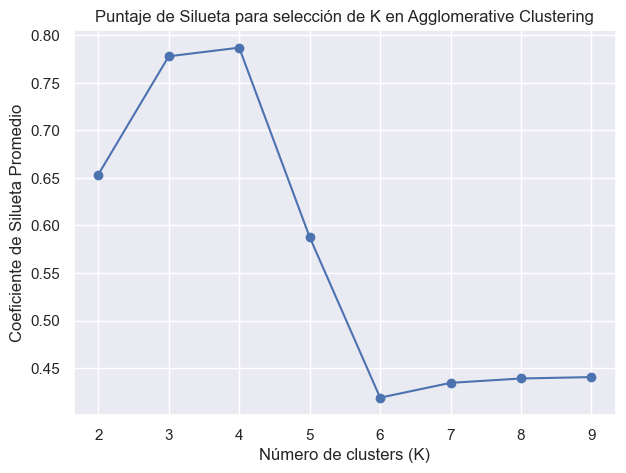

In [236]:
silhouette_scores = []
clusters_range = range(2, 10)

for k in clusters_range:
    aggl_model = AgglomerativeClustering(n_clusters=k)
    labels = aggl_model.fit_predict(X)

    # Calcular el silhouette score
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(7, 5))
plt.plot(clusters_range, silhouette_scores, marker="o")
plt.title("Puntaje de Silueta para selección de K en Agglomerative Clustering")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Coeficiente de Silueta Promedio")
plt.grid(True)
plt.show()

Según este gráfico, el número de clusters que obtiene el mejor coeficiente de silueta es k=4, lo cual es diferente a lo observado en el dendrograma donde se notaban 2 o 3 grupos naturales. Por esto, se harán las gráficas de silueta para k=2, k=3, k=4, k=5 para comparar los resultados y decidir cuál es la mejor opción.


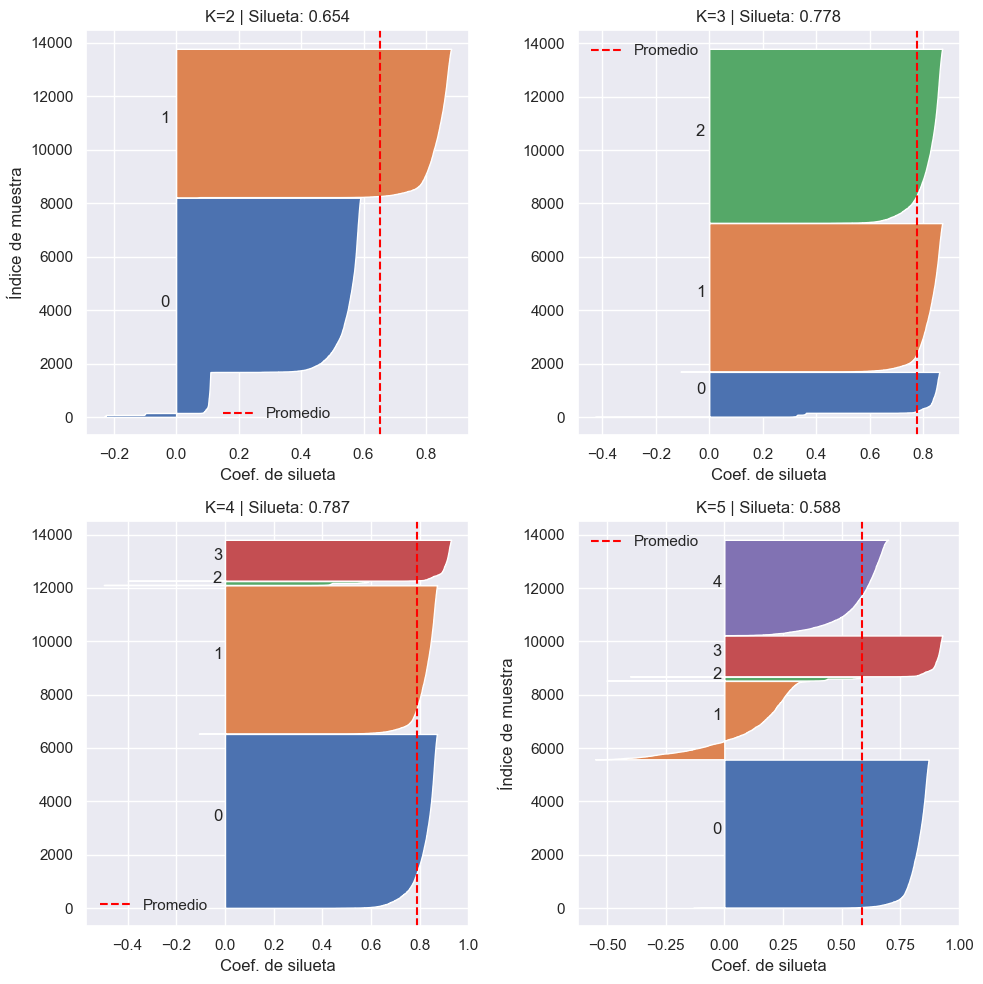

In [248]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

clusters_range = range(2, 6)

for idx, k in enumerate(clusters_range):
    aggl_model = AgglomerativeClustering(n_clusters=k)
    etiquetas = aggl_model.fit_predict(X)
    sil_score = silhouette_score(X, etiquetas)
    sample_silhouette_values = silhouette_samples(df_clean, etiquetas)
    y_lower = 10

    ax = axes[idx]
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[etiquetas == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f"K={k} | Silueta: {sil_score:.3f}")
    ax.set_xlabel("Coef. de silueta")
    ax.set_ylabel("Índice de muestra" if idx in [0, 3] else "")
    ax.axvline(x=sil_score, color="red", linestyle="--", label="Promedio")
    ax.legend()
    

plt.tight_layout()
plt.show()

Observando los gráficos de silueta, se observa que aunque el coeficiente de silueta con k=4 sea mayor, hay un grupo muy pequeño y con un coeficiente de 0.4, casi la mitad de 0.787, por lo que es un grupo que no está bien definido. Por otro lado, k=3 tiene un coeficiente de silueta de 0.778, que es bastante bueno, y los tres grupos tienen coeficientes de silueta relativamente altos, todos por encima del coeficiente promedio de 0.778 para k=3. Por lo tanto, se decide que k=3 es la mejor opción para este conjunto de datos, ya que ofrece un buen equilibrio entre la calidad del clustering y la estabilidad de los grupos formados.


## Análisis de grupos generados por Clustering Aglomerativo


In [249]:
aggl_model = AgglomerativeClustering(n_clusters=3)

labels = aggl_model.fit_predict(X)
print(labels)

[2 1 1 ... 2 0 1]


In [250]:
df_aggl = X.copy()
df_aggl["Cluster"] = labels

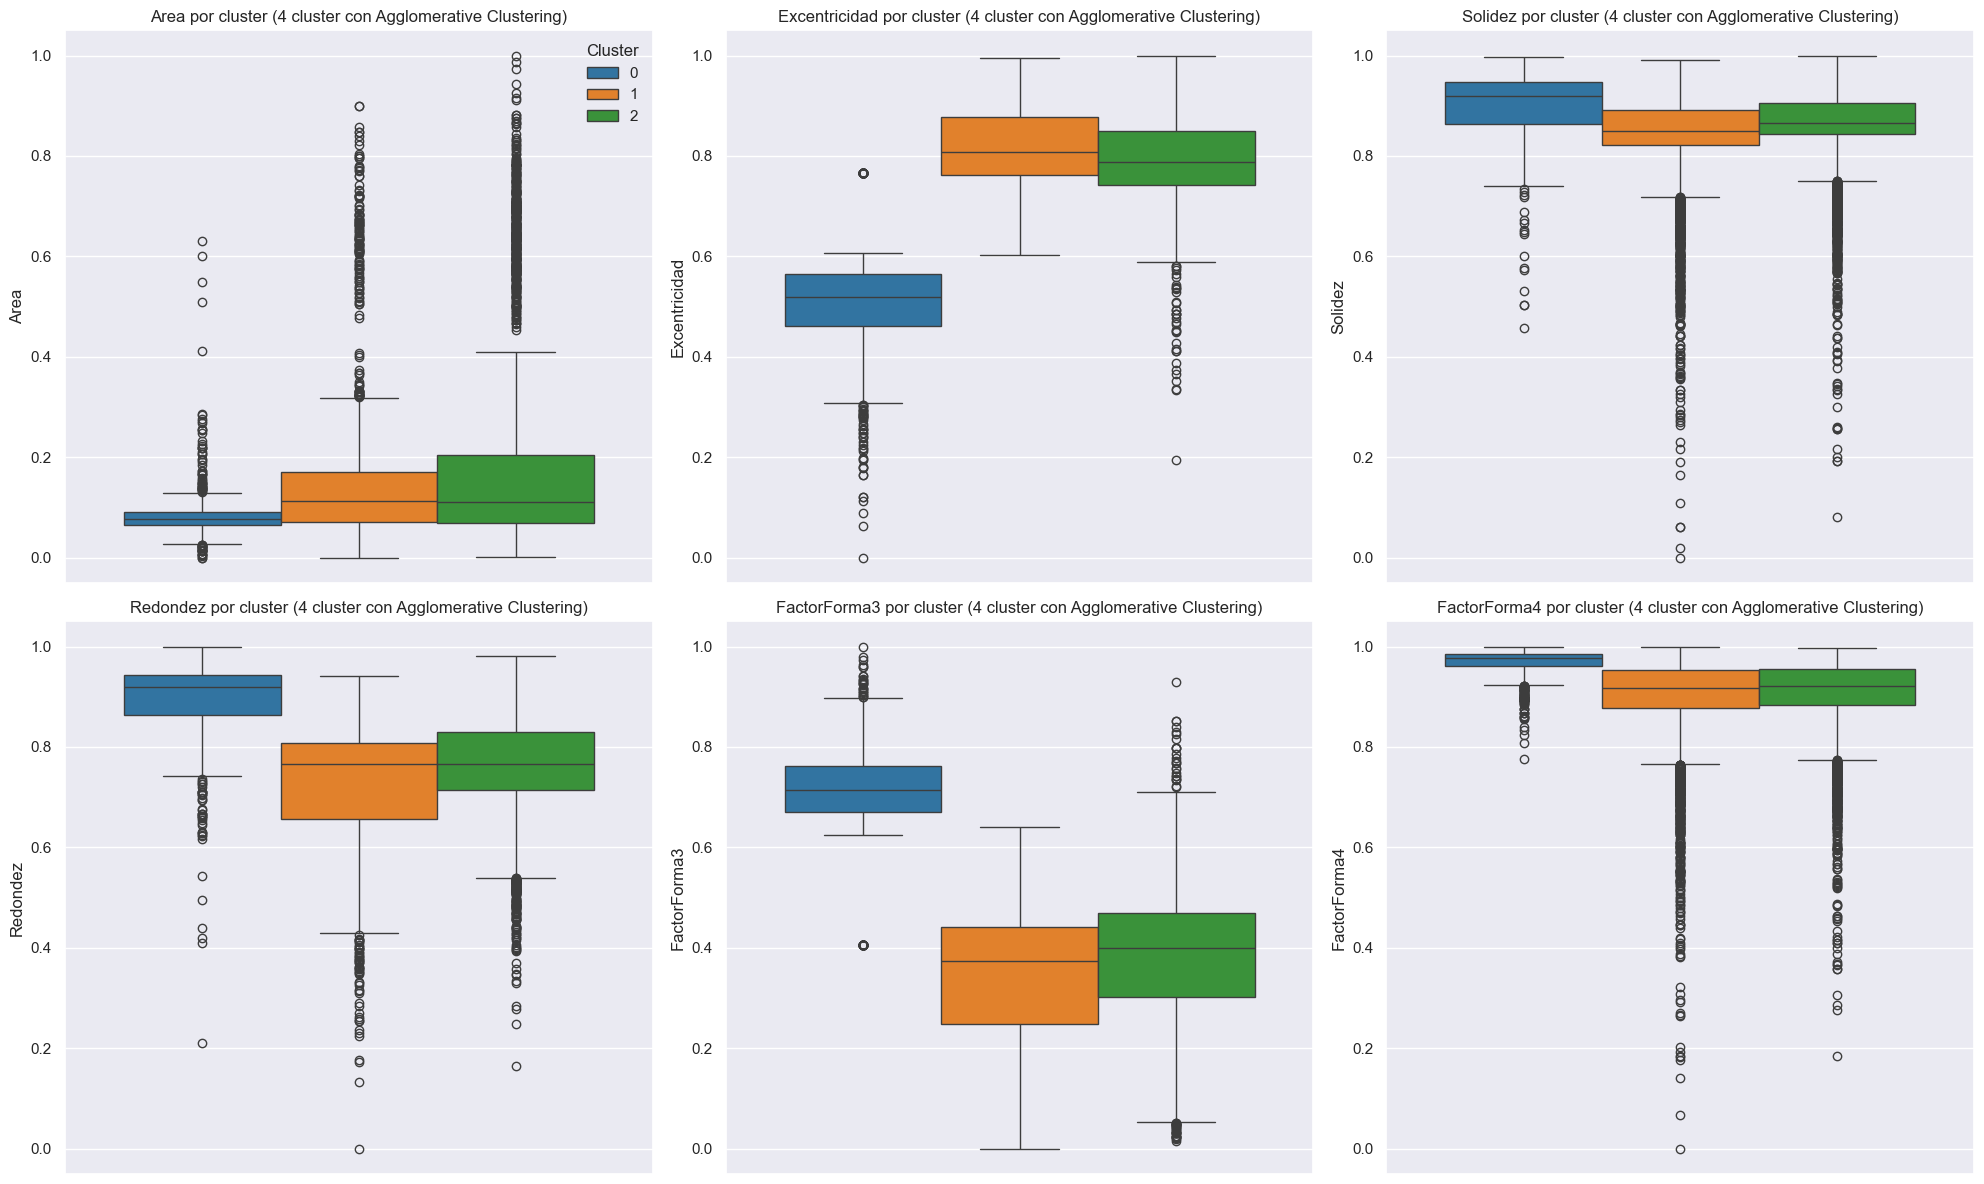

In [251]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

variables = [
    "Area",
    "Excentricidad",
    "Solidez",
    "Redondez",
    "FactorForma3",
    "FactorForma4",
]

for i, var in enumerate(variables):
    sns.boxplot(y=var, data=df_aggl, ax=axes[i], hue="Cluster", palette="tab10")
    axes[i].set_title(f"{var} por cluster (4 cluster con Agglomerative Clustering)")
    if i > 0:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

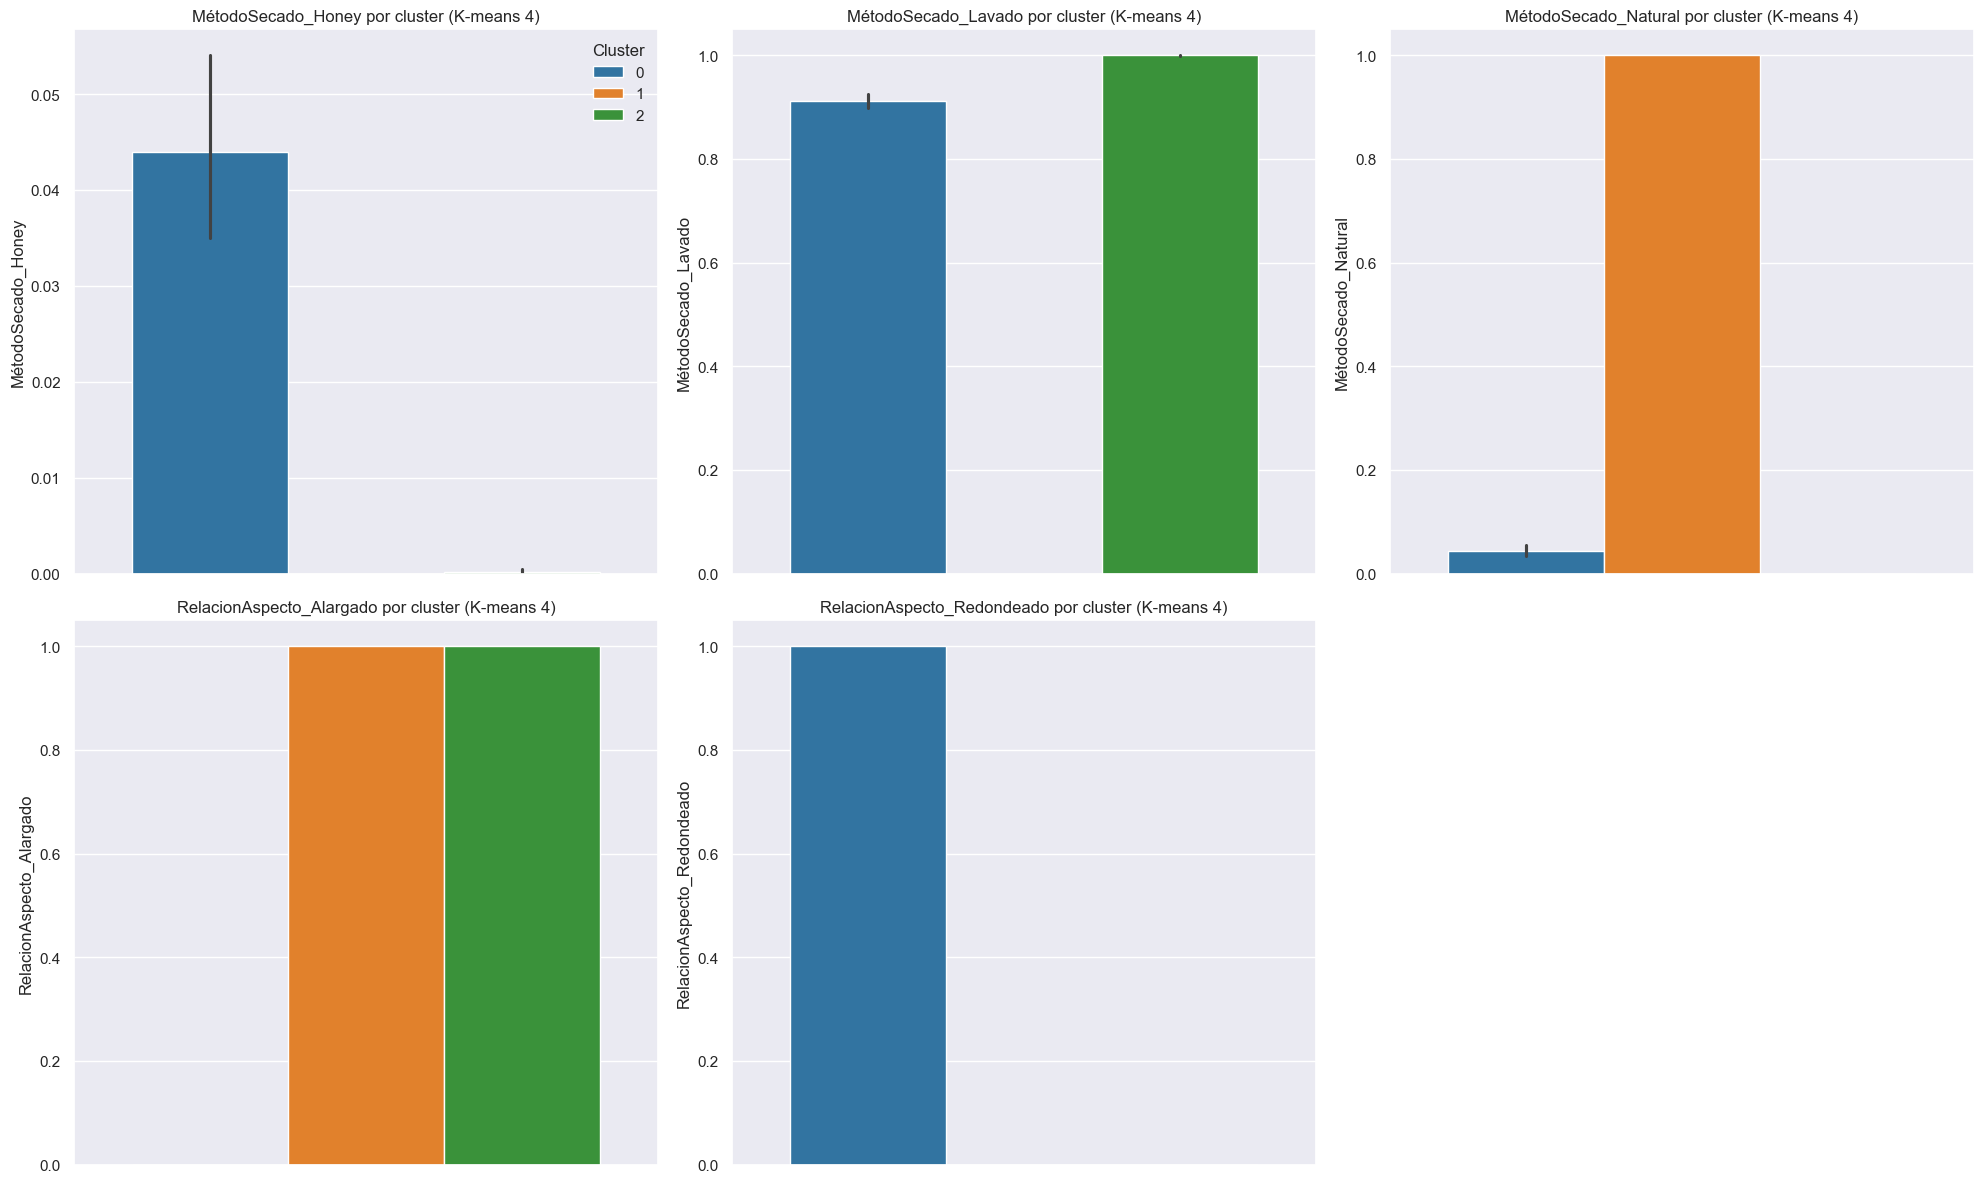

In [252]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

variables = [
    "MétodoSecado_Honey",
    "MétodoSecado_Lavado",
    "MétodoSecado_Natural",
    "RelacionAspecto_Alargado",
    "RelacionAspecto_Redondeado",
]

for i, var in enumerate(variables):
    sns.barplot(y=var, data=df_aggl, ax=axes[i], hue="Cluster", palette="tab10")
    axes[i].set_title(f"{var} por cluster (K-means 4)")
    if i > 0:
        axes[i].get_legend().remove()

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()